<h1><center>Students performance and difficulties prediction</center></h1>

<img src='plots\project.cover\inpt.png' width="242" height="42" style="float:right">
<h3>Project Advisor:</h3>

<a href='https://www.linkedin.com/in/amina-radgui-88017424/' style="text-decoration: none">Prof. RADGUI Amina</a>
    
<h3>Working team:</h3>
    
<a href='https://www.linkedin.com/in/mohammed-al-jadd-a540281b7/' style="text-decoration: none">AL JADD Mohammed</a>
    
<a href='https://www.linkedin.com/in/hafssa-boujida-248aa5202/' style="text-decoration: none">BOUJIDA Hafssa</a>
    
<a href='https://www.linkedin.com/in/nouhaila-elnabaoui-b43b8b19b/' style="text-decoration: none">EL NABAOUI Nouhaila</a>
    
    
    
    

<img src='plots\project.cover\cover.png' width="600" height="600">

<h1><span style='color:#b846a3;font-family:Comic Sans MS'>Thanking :</span></h1>

- We first thank Allah for helping us in that project as well as our families supports.
- We thank also our teacher for giving us everything we need in machine learning during the class sessions

<h1><span style='color:#b846a3;font-family:Comic Sans MS'>Objectives :</span></h1>

In this notebook, we will  :

- **Predict whether or not a student will pass the final exam based on certain information given**
- **Compare the three learning algorithms**
- **Find out what most affects student achievement**
- **Find the best algorithm with high accuracy**

We will be using three learning algorithms:

- **Logistic regression**
- **Supported vector machine**
- **KNN**

# Reading data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, f1_score, roc_auc_score, classification_report
from astropy.table import Table
from sklearn.metrics import roc_auc_score

df = pd.read_csv('student-data.csv')
dfv = pd.read_csv('student-data.csv')

# Data  <h5 style='color:red;font-family:cursive;font-size:4.5mm'>Réalisé par Mohammed AL JADD </h5>

**Before process the dataset let's describe it briefly:**

- *For the sake of applying our skills in machine learning, we will choose an appropriate dataset for our problematic* :<br><br>

    - Source : **Paulo Cortez, University of Minho, GuimarÃ£es, Portugal**, http://www3.dsi.uminho.pt/pcortez

    - This dataset approach students achievement in secondary education of two Portuguese schools.

    - The shape of our data set is **(395 rows × 31 columns)**.

    - **No missing** values in the data, so we do not have to process lines with missing values.

    - The data attributes **include demographic**, social and school related features and it was collected by using school reports and questionnaires. In the following cell we will describe each attribute.

    - **The last column tells us whether or not the student passed the final exam**.

    - The dataset is taken from : https://archive.ics.uci.edu/ml/datasets/student+performance
    
**Now let's explain every column in the dataframe**
- `school` : student's school (binary: "GP" or "MS")
- `sex` : student's sex (binary: "F" - female or "M" - male)
- `age` : student's age (numeric: from 15 to 22)
- `address` : student's home address type (binary: "U" - urban or "R" - rural)
- `famsize` : family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
- `Pstatus` : parent's cohabitation status (binary: "T" - living together or "A" - apart)
- `Medu` : mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)
- `Fedu` : father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)
- `Mjob` : mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
- `Fjob` : father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
- `reason` : reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
- `guardian` : student's guardian (nominal: "mother", "father" or "other")
- `traveltime` : home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
- `studytime` : weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
- `failures` : number of past class failures (numeric: n if 1<=n<3, else 4)
- `schoolsup` : extra educational support (binary: yes or no)
- `famsup` : family educational support (binary: yes or no)
- `paid` : extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
- `activities` : extra-curricular activities (binary: yes or no)
- `nursery` : attended nursery school (binary: yes or no)
- `higher` : wants to take higher education (binary: yes or no)
- `internet` : Internet access at home (binary: yes or no)
- `romantic` : with a romantic relationship (binary: yes or no)
- `famrel` : quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
- `freetime` : free time after school (numeric: from 1 - very low to 5 - very high)
- `goout` : going out with friends (numeric: from 1 - very low to 5 - very high)
- `Dalc` : workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
- `Walc` : weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
- `health` : current health status (numeric: from 1 - very bad to 5 - very good)
- `absences` : number of school absences (numeric: from 0 to 93)

**The last column:**
- `passed` : did the student pass the final exam or not (binary: yes or no)

**Displaying the dataset**

In [2]:
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,no,no,5,5,4,4,5,4,11,no
391,MS,M,17,U,LE3,T,3,1,services,services,...,yes,no,2,4,5,3,4,2,3,yes
392,MS,M,21,R,GT3,T,1,1,other,other,...,no,no,5,5,3,3,3,3,3,no
393,MS,M,18,R,LE3,T,3,2,services,other,...,yes,no,4,4,1,3,4,5,0,yes


## Data processing <h5 style='color:red;font-family:cursive;font-size:4.5mm'>Réalisé par Mohammed AL JADD </h5>

**Before working with any dataset we have to process that dataset so it will be ready for training our models**. **All functions that will be used will be described in the following cell**. 

- **1)** Sometimes, datasets came up with non numerical values and it is impossible to give it to any classifier. So our job is to convert non numeric values to numerical ones. And we will do that by calling:

```python
def numerical_data()
```
     - This function will map each string to an appropriate integer. 
<br>
     
 - **2)** But we can do another thing which is feature scaling. Feature scaling is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step. This will help our learning algorithms to converge quickly. Just by calling :

```python
def feature_scaling(df)
```
       - This function take the dataset as an argument and replace each column, let's say 'col',to :    
$$\frac{col-mean(col)}{max(col)}$$, where $mean$ : the mean or the average.
        
        - But this is not the only scaling you do, it turns out the following equation works well to:    
$$\frac{col-mean(col)}{std(col)}$$, where $std$ : the standard deviation.

In [3]:
# mapping strings to numeric values:
def numerical_data():
    df['school'] = df['school'].map({'GP': 0, 'MS': 1})
    df['sex'] = df['sex'].map({'M': 0, 'F': 1})
    df['address'] = df['address'].map({'U': 0, 'R': 1})
    df['famsize'] = df['famsize'].map({'LE3': 0, 'GT3': 1})
    df['Pstatus'] = df['Pstatus'].map({'T': 0, 'A': 1})
    df['Mjob'] = df['Mjob'].map({'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4})
    df['Fjob'] = df['Fjob'].map({'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4})
    df['reason'] = df['reason'].map({'home': 0, 'reputation': 1, 'course': 2, 'other': 3})
    df['guardian'] = df['guardian'].map({'mother': 0, 'father': 1, 'other': 2})
    df['schoolsup'] = df['schoolsup'].map({'no': 0, 'yes': 1})
    df['famsup'] = df['famsup'].map({'no': 0, 'yes': 1})
    df['paid'] = df['paid'].map({'no': 0, 'yes': 1})
    df['activities'] = df['activities'].map({'no': 0, 'yes': 1})
    df['nursery'] = df['nursery'].map({'no': 0, 'yes': 1})
    df['higher'] = df['higher'].map({'no': 0, 'yes': 1})
    df['internet'] = df['internet'].map({'no': 0, 'yes': 1})
    df['romantic'] = df['romantic'].map({'no': 0, 'yes' : 1})
    df['passed'] = df['passed'].map({'no': 0, 'yes': 1})
    # reorder dataframe columns :
    col = df['passed']
    del df['passed']
    df['passed'] = col

    
# feature scaling will allow the algorithm to converge faster, large data will have same scal
def feature_scaling(df):
    for i in df:
        col = df[i]
        # let's choose columns that have large values
        if(np.max(col)>6):
            Max = max(col)
            Min = min(col)
            mean = np.mean(col)
            col  = (col-mean)/(Max)
            df[i] = col
        elif(np.max(col)<6):
            col = (col-np.min(col))
            col /= np.max(col)
            df[i] = col

**digitization of values**

In [4]:
# All values in numerical after calling numerical_data() function
numerical_data()
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,0,1,18,0,1,1,4,4,3,0,...,0,0,4,3,4,1,1,3,6,0
1,0,1,17,0,1,0,1,1,3,4,...,1,0,5,3,3,1,1,3,4,0
2,0,1,15,0,0,0,1,1,3,4,...,1,0,4,3,2,2,3,3,10,1
3,0,1,15,0,1,0,4,2,1,2,...,1,1,3,2,2,1,1,5,2,1
4,0,1,16,0,1,0,3,3,4,4,...,0,0,4,3,2,1,2,5,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,0,20,0,0,1,2,2,2,2,...,0,0,5,5,4,4,5,4,11,0
391,1,0,17,0,0,0,3,1,2,2,...,1,0,2,4,5,3,4,2,3,1
392,1,0,21,1,1,0,1,1,4,4,...,0,0,5,5,3,3,3,3,3,0
393,1,0,18,1,0,0,3,2,2,4,...,1,0,4,4,1,3,4,5,0,1


    - Now, all the values in the dataset are numerical.

**Features scalling**

In [5]:
# Let's scal our features
feature_scaling(df)

# Now we are ready for models training
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,0.0,1.0,0.059264,0.0,1.0,1.0,1.00,1.00,0.75,0.00,...,0.0,0.0,0.75,0.50,0.75,0.00,0.00,0.50,0.003882,0.0
1,0.0,1.0,0.013809,0.0,1.0,0.0,0.25,0.25,0.75,1.00,...,1.0,0.0,1.00,0.50,0.50,0.00,0.00,0.50,-0.022785,0.0
2,0.0,1.0,-0.077100,0.0,0.0,0.0,0.25,0.25,0.75,1.00,...,1.0,0.0,0.75,0.50,0.25,0.25,0.50,0.50,0.057215,1.0
3,0.0,1.0,-0.077100,0.0,1.0,0.0,1.00,0.50,0.25,0.50,...,1.0,1.0,0.50,0.25,0.25,0.00,0.00,1.00,-0.049451,1.0
4,0.0,1.0,-0.031646,0.0,1.0,0.0,0.75,0.75,1.00,1.00,...,0.0,0.0,0.75,0.50,0.25,0.00,0.25,1.00,-0.022785,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1.0,0.0,0.150173,0.0,0.0,1.0,0.50,0.50,0.50,0.50,...,0.0,0.0,1.00,1.00,0.75,0.75,1.00,0.75,0.070549,0.0
391,1.0,0.0,0.013809,0.0,0.0,0.0,0.75,0.25,0.50,0.50,...,1.0,0.0,0.25,0.75,1.00,0.50,0.75,0.25,-0.036118,1.0
392,1.0,0.0,0.195627,1.0,1.0,0.0,0.25,0.25,1.00,1.00,...,0.0,0.0,1.00,1.00,0.50,0.50,0.50,0.50,-0.036118,0.0
393,1.0,0.0,0.059264,1.0,0.0,0.0,0.75,0.50,0.50,1.00,...,1.0,0.0,0.75,0.75,0.00,0.50,0.75,1.00,-0.076118,1.0


# Data visualisation  <h5 style='color:red;font-family:cursive;font-size:4.5mm'>Réaliser par el "nabaoui nouhaila" et "boujida hafssa" good lecture:) </h5>

## 1) data inspection

In [6]:
df.shape

(395, 31)

In [7]:
df.dropna().shape # their is no null value "fortunately:)"

(395, 31)

In [8]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'passed'],
      dtype='object')

In [9]:
features=['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences']

Réaliser par el "nabaoui nouhaila" et "boujida hafssa" good lecture:)

## 2)features visualisation


-firstly we are going to look deeper into each features by using multiple methods of visualisation such as distribution plot ,Density...
After the visualisation we are going to understand wish features are most impactfull for  student's performances.

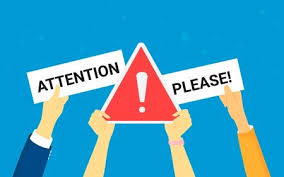

If you are students,parents or teachers and you care about your kids or students academic performances you might want to have attention for next lectures, wi will provides you with  summary of how you can achieve best social,demographic and school conditions to boost their academics potentials.

In [10]:
#plot of student status
dfv['passed'].value_counts()

yes    265
no     130
Name: passed, dtype: int64

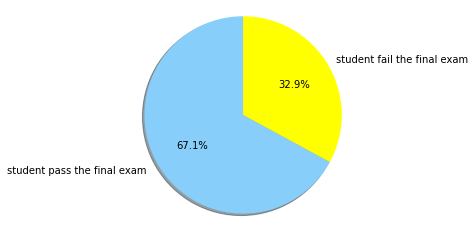

In [11]:
labels = 'student pass the final exam ', 'student fail the final exam'
sizes = [265, 130]
colors=['lightskyblue','yellow']
fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',colors=colors,
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Likely most of student passed the exam ,our goal is to decrease the student failure as max as possible.

 ### a)Correlation heatmap

   #### -a.1) general hetmap

Text(0.5, 1.0, 'Correlation Heatmap')

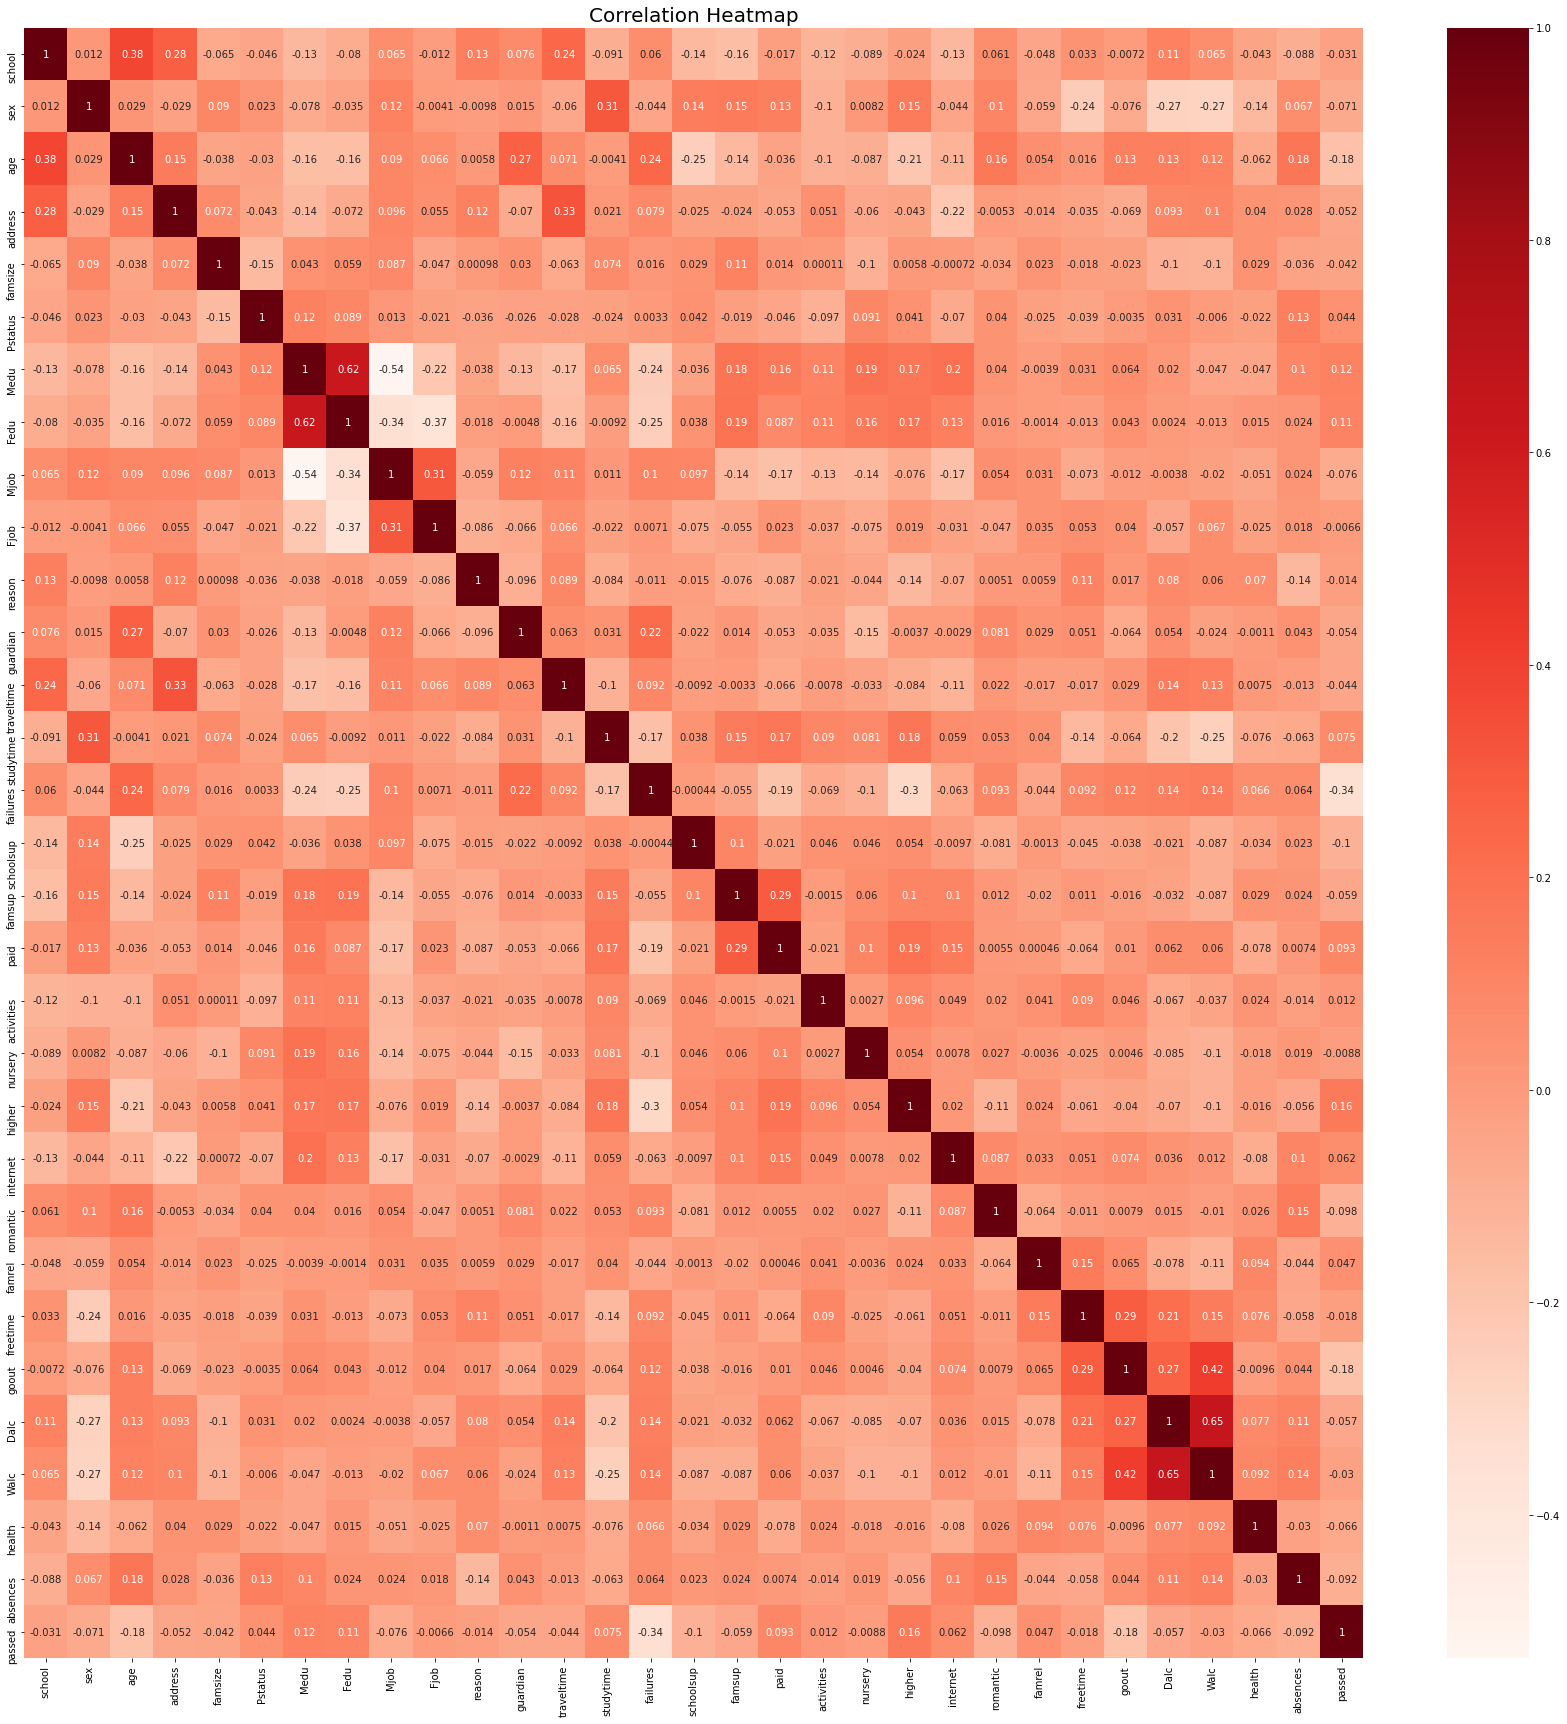

In [12]:
# see correlation between variables through a correlation heatmap
corr = df.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, annot=True, cmap="Reds")
plt.title('Correlation Heatmap', fontsize=20)

#### a.2)correlation between student status and other features

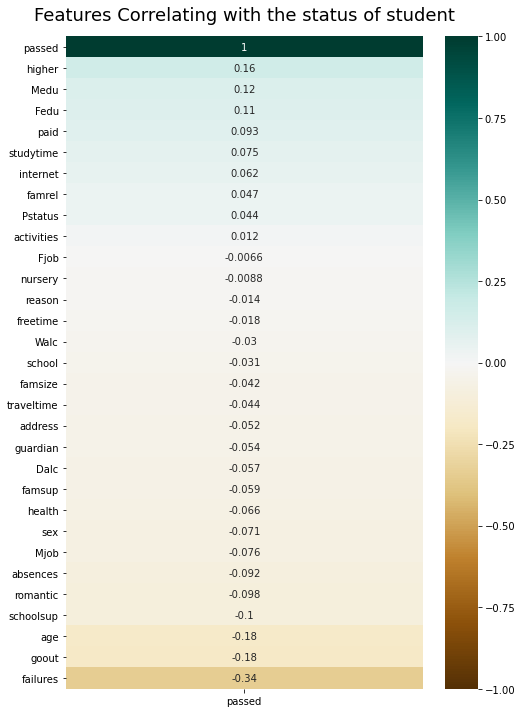

In [13]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['passed']].sort_values(by='passed', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with the status of student', fontdict={'fontsize':18}, pad=16);

C0:Based on this heatmap we can do a quiq conclusion about most impactfull features on student status:

**tree most impactfull (positively) features**:

-mother and father with height education had a positif impact on student performance

-the students who wants to take higher education are having also good grades sow it could be better to tell student how great and fun to take higher education 

**tree most impactfull (negatively) features**:

-going out with friends to much hours can impact badely

-age and failures are other features that also impact negatively the student performances.

In next steps we will confirm this conclusions by using distribution plot,density graphs.....

### b) Distribution plot

In this step let's look deeper into each features and make a final summary for best social,demographic and school conditions.

#### b.1) Student status  By goout

<img src='plots\visualisation.images\g.o.png' width='470cm' height='390cm'>

In [14]:
df["goout"].unique()

array([0.75, 0.5 , 0.25, 0.  , 1.  ])

Text(0.5, 0, 'Student status')

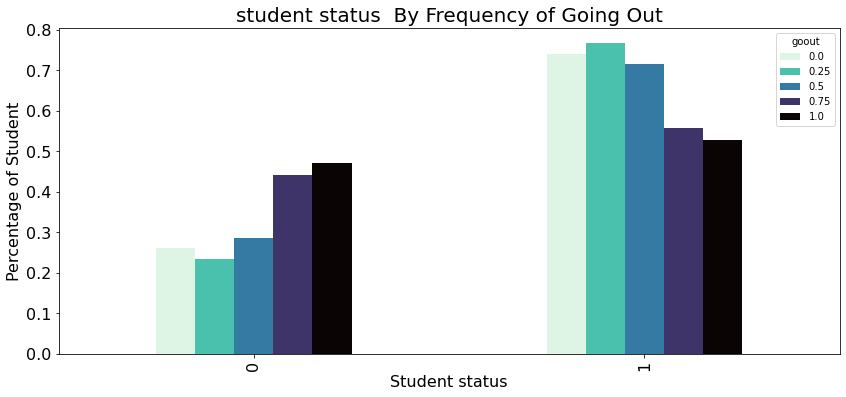

In [15]:
# going out
perc = (lambda col: col/col.sum())
index = [0,1]
out_tab = pd.crosstab(index=df.passed, columns=df.goout)
out_perc = out_tab.apply(perc).reindex(index)
out_perc.plot.bar(colormap="mako_r", fontsize=16, figsize=(14,6))
plt.title('student status  By Frequency of Going Out', fontsize=20)
plt.ylabel('Percentage of Student', fontsize=16)
plt.xlabel('Student status', fontsize=16)

-C1: it seems that most of people who passed the exam had less hour of going out ,as a conclusion we should limit the hour of going out with friend

#### b.2)Student status by romantic relation:

<img src='plots\visualisation.images\romantic.jpg' width='300cm' height='240cm'>

<Figure size 432x288 with 0 Axes>

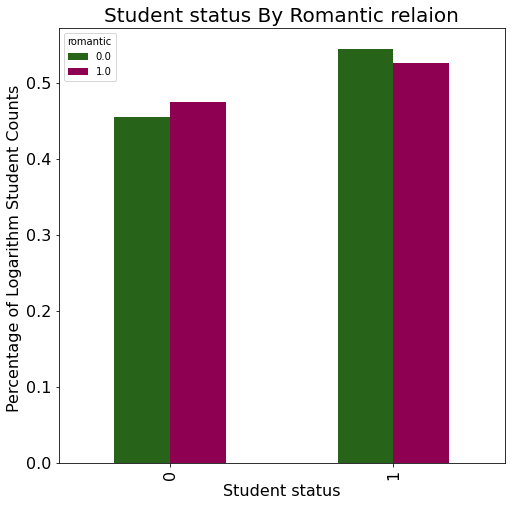

In [16]:
# romantic status
romance_tab1 = pd.crosstab(index=df.passed, columns=df.romantic)
romance_tab = np.log(romance_tab1)
romance_perc = romance_tab.apply(perc).reindex(index)
plt.figure()
romance_perc.plot.bar(colormap="PiYG_r", fontsize=16, figsize=(8,8))
plt.title('Student status By Romantic relaion', fontsize=20)
plt.ylabel('Percentage of Logarithm Student Counts ', fontsize=16)
plt.xlabel('Student status', fontsize=16)
plt.show()
# 0 in romantic mean no romantic relation 

-C2:Most of people whow passed the exam had no romantic relation ,sow no relation could be a good choice for better performance.

#### b.3)Student status by  mother job and mother education:

<img src='plots\visualisation.images\mother.education.png' width='200cm' height='200cm'>

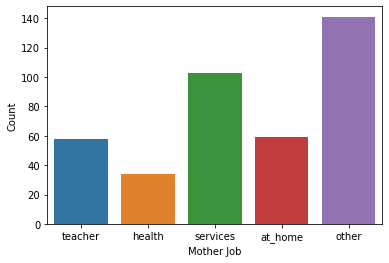

In [17]:
# 1) mother job 
# Mjob distribution
f, fx = plt.subplots()
figure = sns.countplot(x = 'Mjob', data=dfv, order=['teacher','health','services','at_home','other'])
fx = fx.set(ylabel="Count", xlabel="Mother Job")
figure.grid(False)

<Figure size 432x288 with 0 Axes>

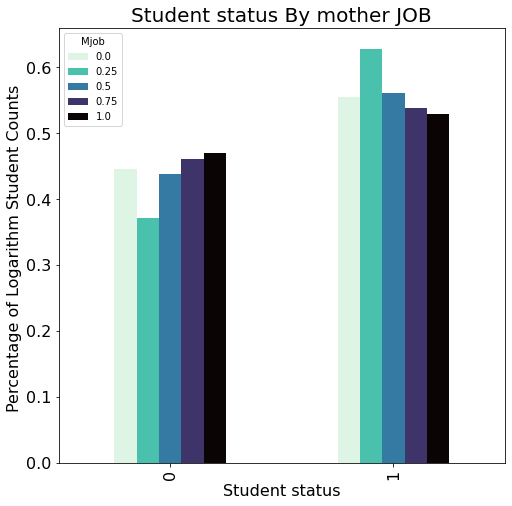

In [18]:
mjob_tab1 = pd.crosstab(index=df.passed, columns=df.Mjob)
mjob_tab = np.log(mjob_tab1)
mjob_perc = mjob_tab.apply(perc).reindex(index)
plt.figure()
mjob_perc.plot.bar(colormap="mako_r", fontsize=16, figsize=(8,8))
plt.title('Student status By mother JOB', fontsize=20)
plt.ylabel('Percentage of Logarithm Student Counts ', fontsize=16)
plt.xlabel('Student status', fontsize=16)
plt.show()
#'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4

C3:It's seems that students who's mother work as doctor reach good status

<ipython-input-19-b5ac6f534e4c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good['good_student_mother_education'] = good.Medu
<ipython-input-19-b5ac6f534e4c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poor['poor_student_mother_education'] = poor.Medu


Text(0.5, 0, 'Mother Education Level')

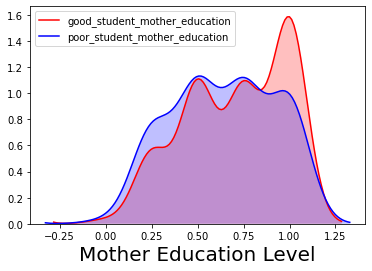

In [19]:
#Mother education:
good = df.loc[df.passed==1]
poor=df.loc[df.passed==0]
good['good_student_mother_education'] = good.Medu
poor['poor_student_mother_education'] = poor.Medu
plt.figure(figsize=(6,4))
p=sns.kdeplot(good['good_student_mother_education'], shade=True, color="r")#good_student in red
p=sns.kdeplot(poor['poor_student_mother_education'], shade=True, color="b")#poor_student in blue
plt.xlabel('Mother Education Level', fontsize=20)

C4:Mother height education had good impact in student status.If we look into the second heatmap previousely it seems that Medu is more impactfful than Fedu sow if you are woman study hard ,if you are man marry a woman with higher education.


#### b.4)Student status by deseire to take heigher education:

<img src='plots\visualisation.images\Heigher.edu.jpg' width='260cm' height='290cm'>

Text(0, 0.5, 'Percentage of Student')

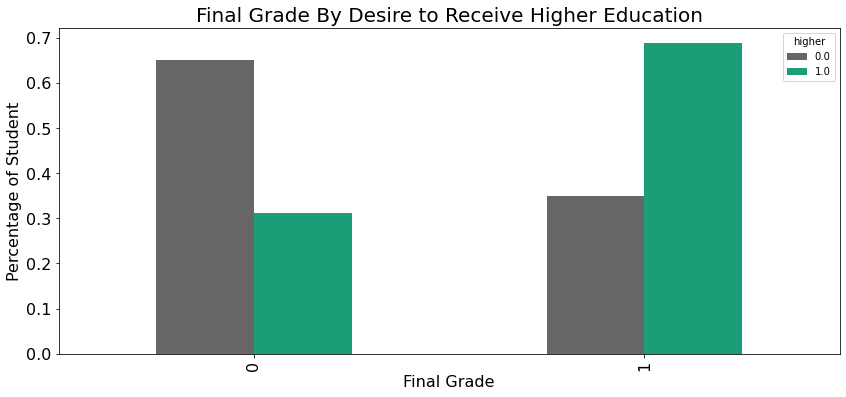

In [20]:
higher_tab = pd.crosstab(index=df.passed, columns=df.higher)
higher_perc = higher_tab.apply(perc).reindex(index)
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('Final Grade By Desire to Receive Higher Education', fontsize=20)
plt.xlabel('Final Grade', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

C4:Most of people who passed the exam want to take heigher education sow it could be a good idea to encourage your kids or students to take heigher education.

#### b.5)Student status by age 

<img src='plots\visualisation.images\age.jpg' width='260cm' height='290cm'>

Text(0, 0.5, 'Percentage of Student')

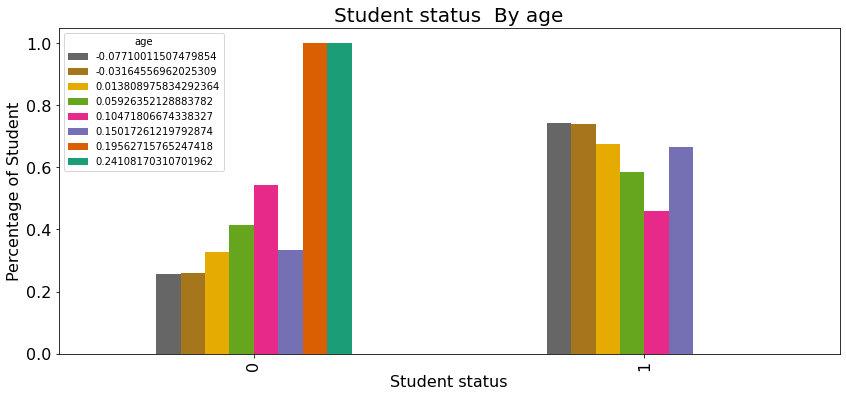

In [21]:
#impact of age
higher_tab = pd.crosstab(index=df.passed, columns=df.age)
higher_perc = higher_tab.apply(perc).reindex(index)
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('Student status  By age', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)


C5:Age also play an importent role in student sucess, most of people who passed the exam had early age 15, and most people who failed the exam had an age of 22 .As a conclusion it could be better to go to school in early age.

#### b.6) Student status by failures:

In [22]:
#impact of failures

<img src='plots\visualisation.images\fail.jpg' width='280cm' height='320cm'>

Text(0, 0.5, 'Percentage of Student')

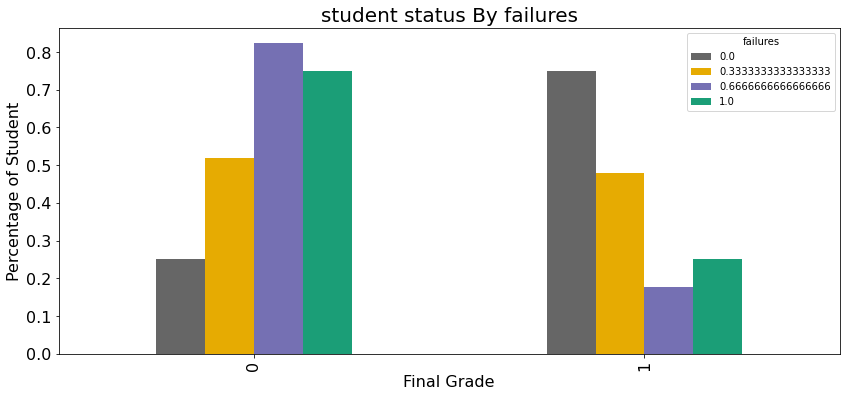

In [23]:
fail_tab = pd.crosstab(index=df.passed, columns=df.failures)
fail_perc = fail_tab.apply(perc).reindex(index)
fail_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By failures', fontsize=20)
plt.xlabel('Final Grade', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

C6:most of people who passed the exam had 0failures sow it could be a good choice to study hard and pass all the grades

#### b.7) Student status by area


<img src='plots\visualisation.images\city.vs.contry.side.png' width='460cm' height='490cm'>

Text(0.5, 1.0, 'Address Distribution')

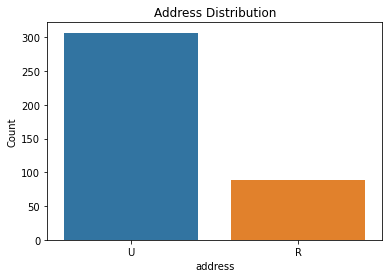

In [24]:
#first let's see the destribution of students who live in urban or rural area
f, fx = plt.subplots()
figure = sns.countplot(x = 'address', data=dfv, order=['U','R'])
fx = fx.set(ylabel="Count", xlabel="address")
figure.grid(False)
plt.title('Address Distribution')

Text(0.5, 0, 'Student status')

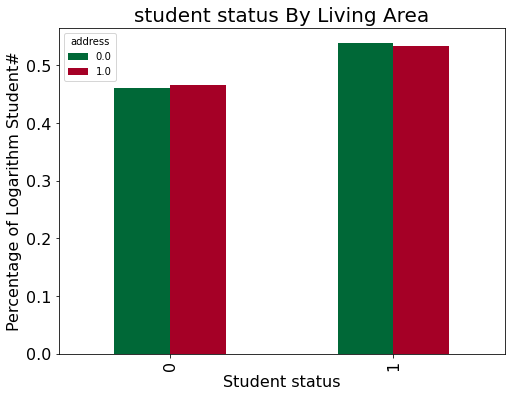

In [25]:
ad_tab1 = pd.crosstab(index=df.passed, columns=df.address)
ad_tab = np.log(ad_tab1)
ad_perc = ad_tab.apply(perc).reindex(index)
ad_perc.plot.bar(colormap="RdYlGn_r", fontsize=16, figsize=(8,6))
plt.title('student status By Living Area', fontsize=20)
plt.ylabel('Percentage of Logarithm Student#', fontsize=16)
plt.xlabel('Student status', fontsize=16)

C7:Area doesn't had an impact on student performance even people with good results live in contry side

#### b.8) Student status by alchool consumption :

<img src='plots\visualisation.images\alc.jpg' width='400cm' height='400cm'>

Text(0, 0.5, 'Percentage of Student')

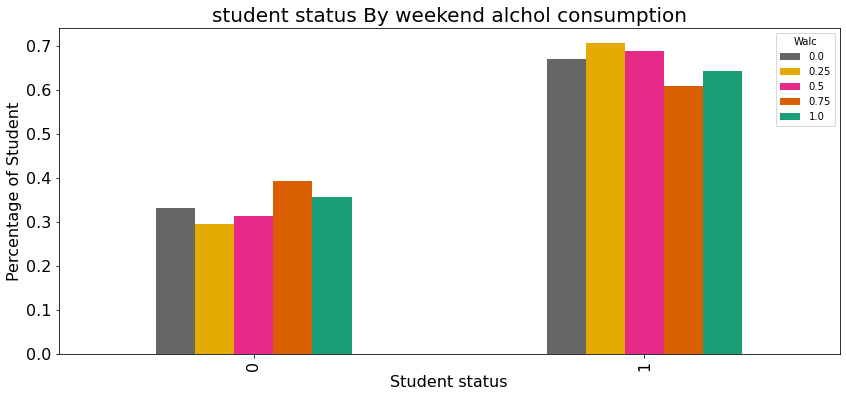

In [26]:
#impact of weekend alcohol consumption in student performance
alc_tab = pd.crosstab(index=df.passed, columns=df.Walc)
alc_perc = alc_tab.apply(perc).reindex(index)
alc_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By weekend alchol consumption', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

<ipython-input-27-3df7c3a0a2b6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good['good_alcohol_usage']=good.Walc
<ipython-input-27-3df7c3a0a2b6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poor['poor_alcohol_usage']=poor.Walc


Text(0.5, 0, 'Level of Alcohol Consumption')

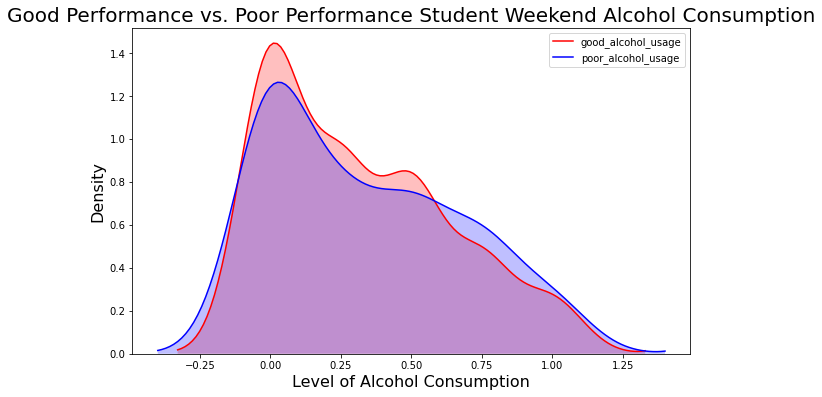

In [27]:
# weekend alcohol consumption
# create good student dataframe
good = df.loc[df.passed == 1]
good['good_alcohol_usage']=good.Walc
# create poor student dataframe
poor = df.loc[df.passed == 0]
poor['poor_alcohol_usage']=poor.Walc
plt.figure(figsize=(10,6))
p1=sns.kdeplot(good['good_alcohol_usage'], shade=True, color="r")
p1=sns.kdeplot(poor['poor_alcohol_usage'], shade=True, color="b")
plt.title('Good Performance vs. Poor Performance Student Weekend Alcohol Consumption', fontsize=20)
plt.ylabel('Density', fontsize=16)
plt.xlabel('Level of Alcohol Consumption', fontsize=16)

For weekely alchool consumption it doesn't have an strong impact on student performance .Even people with low consumption had low grad.

#### b.9) Student status by internet accessibility:

<img src='plots\visualisation.images\internet.accessibility.jpg' width='400cm' height='400cm'>

Text(0, 0.5, 'Percentage of Student')

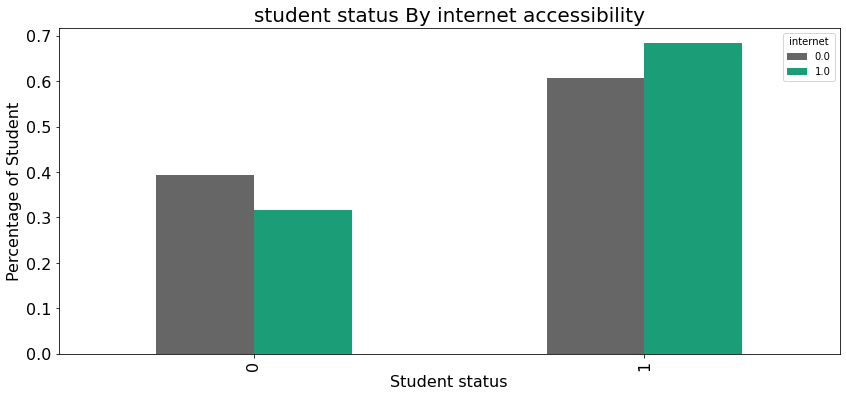

In [28]:
alc_tab = pd.crosstab(index=df.passed, columns=df.internet)
alc_perc = alc_tab.apply(perc).reindex(index)
alc_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By internet accessibility', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)


C9:Most of people who passed the exam had the accessibility to internet ,sow we should provide a fair materials's education

#### b.10) Student status by wekelly Study time :

Text(0, 0.5, 'Percentage of Student')

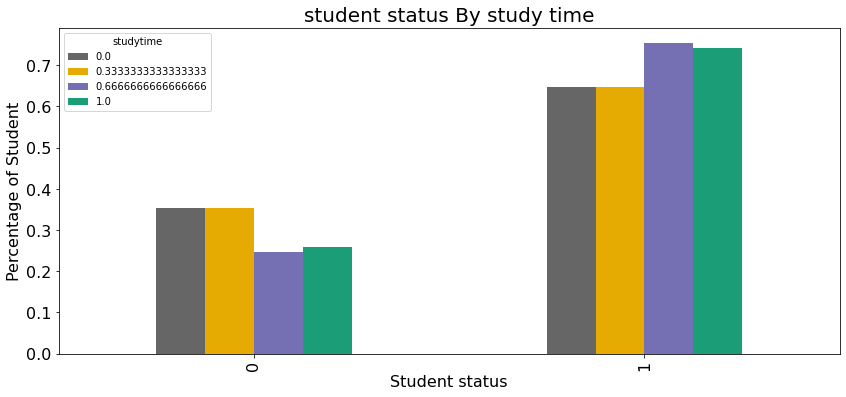

In [29]:
stu_tab = pd.crosstab(index=df.passed, columns=df.studytime)
stu_perc = stu_tab.apply(perc).reindex(index)
stu_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By study time', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)


C10:Most of people who passed the exam study 5-10 hours weekely

#### b.11)Student status by health:

<img src='plots\visualisation.images\health.jpg' width='400cm' height='400cm'>

Text(0, 0.5, 'Percentage of Student')

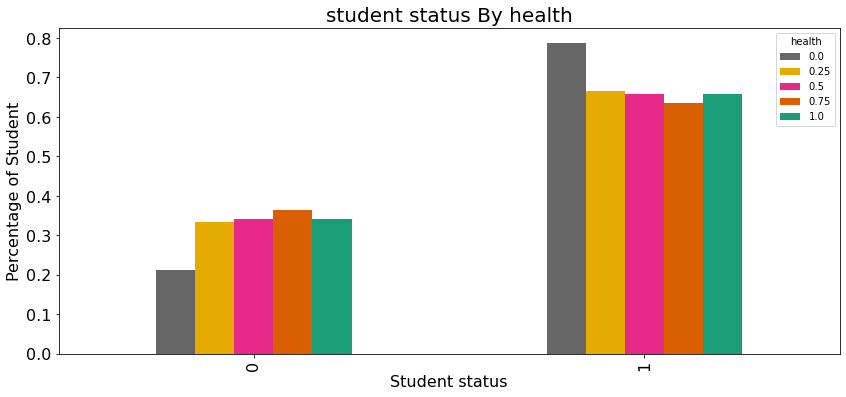

In [30]:
he_tab = pd.crosstab(index=df.passed, columns=df.health)
he_perc = he_tab.apply(perc).reindex(index)
he_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By health', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)


C11:most of student who fails the exam don't have a good health

In [31]:
#making summary for good condition to reach heigh academic potentials:

### 3) General conclusion :

#### Summary:

After dealing with the most relevent features ,the valedictorian of an exellents conditions for heigh academic  potentials is likely to have this profile:

1.Does not go out with friend frequently 

2.Is not in romantic relation

3.Parents receive higher education specialy woman

4.Have strong desire to receive higher education 

5.Mother is a health care professional

6.father is a teacher

7.No absences to classes

8.have access to internet

9.study more than 10 hours a week

10.Is healthy

# Logistic regression  <h5 style='color:red;font-family:cursive;font-size:4.5mm'>Réaliser par boujida hafssa </h5>

# 1-Logistic Regression implementation

In [32]:
# split data train 70 % and test 30 %

data = df.to_numpy()
n = data.shape[1]
x = data[:,0:n-1]
y = data[:,n-1]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Once our data is split, we can forget about x_test and y_test until we define our model.
#x_train and y_train are the samples we will use to train the model

In [33]:
# let's create a model and train it 

logisticRegr = LogisticRegression(C=1)

In [34]:
#and now let's do the training

logisticRegr.fit(x_train,y_train)

LogisticRegression(C=1)

In [35]:
#The model is now trained and ready to make predictions :) 

In [36]:
y_pred=logisticRegr.predict(x_test)
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.])

# 2-Model evaluation

In order to evaluate our model , we will first calculate the accuracy of the model , visualize the confusion matrix, and then plot the ROC curve.

In [37]:
#let's have a look at the accuracy of the model

Sctest=logisticRegr.score(x_test,y_test)
Sctrain=logisticRegr.score(x_train,y_train)

print('#Accuracy test is: ',Sctest)
print('#Accuracy train is: ',Sctrain)


f1 = f1_score(y_test, y_pred, average='macro')

print('\n#f1 score is: ',f1)

#Accuracy test is:  0.6386554621848739
#Accuracy train is:  0.7463768115942029

#f1 score is:  0.5533734834598935


#
We got two values of the accuracy, one obtained with the training set and other with the test set.

It might be a good idea to compare the two, as a situation where the training set accuracy is much higher might indicate overfitting. The test set accuracy is more relevant for evaluating the performance on unseen data since it’s not biased.

In [38]:
#let's have a look at the accuracy of the model

Sctest=logisticRegr.score(x_test,y_test)
Sctrain=logisticRegr.score(x_train,y_train)

print('Accuracy test is: ',Sctest)
print('Accuracy train is: ',Sctrain)

Accuracy test is:  0.6386554621848739
Accuracy train is:  0.7463768115942029


In [39]:
#now, we can get the confusion matrix with confusion_matrix():

confusion_matrix(y_test, y_pred)

array([[12, 38],
       [ 5, 64]], dtype=int64)

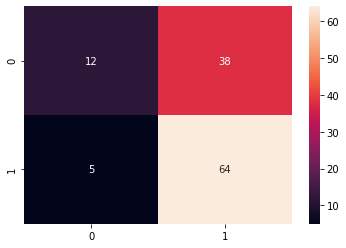

In [40]:
#let's visualize the confusion matrix:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)

We can now get the report on classification as a string or dictionary with classification_report():

In [41]:
#import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.24      0.36        50
         1.0       0.63      0.93      0.75        69

    accuracy                           0.64       119
   macro avg       0.67      0.58      0.55       119
weighted avg       0.66      0.64      0.58       119



ROC CURVE

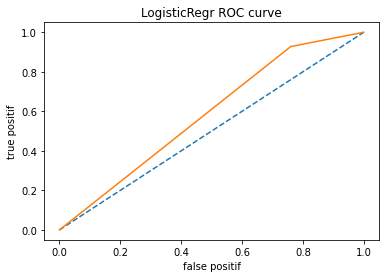

In [42]:
#ploting the roc_curve

fpositif, tpositif, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'--')
plt.plot(fpositif,tpositif, label='LogisticRegr')
plt.xlabel('false positif')
plt.ylabel('true positif')
plt.title('LogisticRegr ROC curve')
p=plt.show()

#we still need to improve our model in order to be more accurate!

# 3-improving model accuracy

Now, we are going to use random state to randomly split the data into training & test set.

The algorithm gives different accuracy each time we change the data split. And we know that if we built a good model, then the accuracy should not vary too much depending on the random state. 
...But still, we can train the model for some iterations and instead of using the values "0" and "1" for the random state, we will choose the value "optimal_state" that maximizes the accuracy and the F1 score for the iterations given.




*Accuracy is: 80.67226890756302
*f1 score is:  0.7408389357068459


 *the ROC curve: 


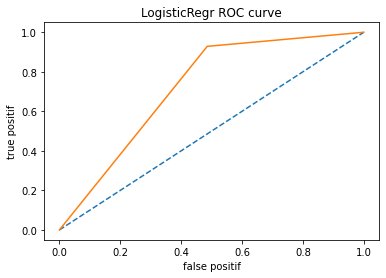

 *the confusion matrix 


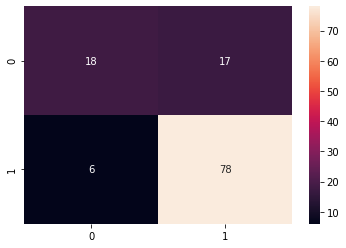

In [43]:
max_iteration = 0
maxF1 = 0
maxAccuracy = 0
optimal_state = 0
import random
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+ ', Current f1 : '+str(maxF1), end="\r")
    split_state = np.random.randint(1,100000000)-1
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=split_state)
    logisticRegr = LogisticRegression(C=1)
    logisticRegr.fit(x_train,y_train)
    y_pred=logisticRegr.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)*100
    
    if (accuracy>maxAccuracy and f1>maxF1):
        maxF1 = f1 
        maxAccuracy = accuracy
        optimal_state = split_state
    
   
optimal_state = 85491961
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=optimal_state)
logisticRegr = LogisticRegression(C=1)
logisticRegr.fit(x_train,y_train)
y_pred=logisticRegr.predict(x_test)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)*100
print('\n\n\n*Accuracy is: '+str(accuracy)+'\n*f1 score is: ',f1)

yt_lg,yp_lg = y_test,y_pred
#ploting the roc_curve

print ( '\n\n *the ROC curve: ')

fpositif, tpositif, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'--')
plt.plot(fpositif,tpositif, label='LogisticRegr')
plt.xlabel('false positif')
plt.ylabel('true positif')
plt.title('LogisticRegr ROC curve')
p=plt.show()


#visualizig the confusion matrix:

print (' *the confusion matrix ')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)

# conclusion
we notice that we went from an accuracy of 64% to 80.67%.
and we got a higher value for F1 score as well ; from 0.55 to 0.74  . 

# k-nearest neighbors <h5 style='color:red;font-family:cursive;font-size:4.5mm'>Réaliser par el nabaoui nouhaila </h5>

<img src='plots\visualisation.images\knn.png' width='400cm' height='400cm'>

---------------------------------# **Réalisée par el nabaoui nouhaila** #------------------------------------------------------------

<h5 style='color:red;font-family:cursive;font-size:4.5mm'> 1 the Goals of this part:</h5>

- in this part we are trying to achieve the following goals:

   - understand knn algorithm and its parameters
   - understand the imapct of knn_hyper_parameters_tuning
   - using multiple method to make the acquracy better
   - finding the best model that provides us with the higher accuracy

<h5 style='color:red;font-family:cursive;font-size:4.5mm'> 2 KNN INTRODUCTION:</h5>

K-nearest neighbors (KNN) algorithm is a type of supervised ML algorithm which can be used for both classification as well as regression predictive problems. However, it is mainly used for classification predictive problems in industry. The following two properties would define KNN well :

Lazy learning algorithm:
    
    − KNN is a lazy learning algorithm because it does not have a specialized training phase and uses all the data for training while classification
    
Non-parametric learning algorithm:
    
    − KNN is also a non-parametric learning algorithm because it doesn’t assume anything about the underlying data.

<h5 style='color:red;font-family:cursive;font-size:4.5mm'>3 Implementation :</h5>

In [44]:
#define data
y=df.passed
target=["passed"]
x = df.drop(target,axis = 1 )

<h5 style='color:blue;font-family:cursive;font-size:4.5mm'>First step: </h5>

Before tuning  the parameters of knn algorithme(value of K,metrics)it could be a good idea to tune the optimal random state before spliting the data and fit it to knn.For this reason we are going to choose as previosely a method that return the "optimal_state" that maximizes the accuracy and the F1 score for the iterations given.

In this step we will not specify the parameters of knn specially the k_value and metrics and after we will evaluate the model and try to understand the impact of knn_hyper_parameters_tuning.




*Accuracy is: 78.15126050420169
*f1 score is:  0.7102996254681648
random_state is  71027464


 *the ROC curve: 


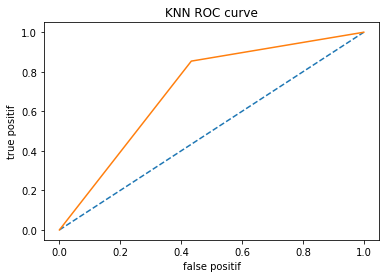

 *the confusion matrix 


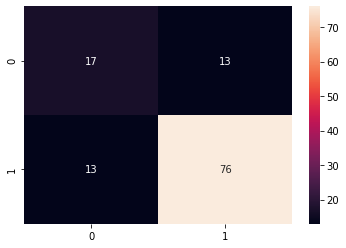

In [45]:
max_iteration = 0
maxF1 = 0
maxAccuracy = 0
optimal_state = 0
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+ ', Current f1 : '+str(maxF1), end="\r")
    split_state = np.random.randint(1,100000000)-1
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=split_state)
    KNN = KNeighborsClassifier()
    KNN.fit(x_train,y_train)
    y_pred=KNN.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)*100
    
    if (accuracy>maxAccuracy and f1>maxF1):
        maxF1 = f1 
        maxAccuracy = accuracy
        optimal_state = split_state
    
optimal_state = 71027464

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=optimal_state)
KNN= KNeighborsClassifier()
KNN.fit(x_train,y_train)
y_pred=KNN.predict(x_test)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)*100
print('\n\n\n*Accuracy is: '+str(accuracy)+'\n*f1 score is: ',f1)

print ('random_state is ',optimal_state)


#ploting the roc_curve

print ( '\n\n *the ROC curve: ')

fpositif, tpositif, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'--')
plt.plot(fpositif,tpositif, label='knn')
plt.xlabel('false positif')
plt.ylabel('true positif')
plt.title('KNN ROC curve')
p=plt.show()

yt_knn,yp_knn= y_test,y_pred
#visualizig the confusion matrix:

print (' *the confusion matrix ')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)

As we can see the best random state are 71027464  corresponding to an accuracy of **78%** wish is a good accuracy

### Model evaluation :

-we evaluate this model and see the impact of knn_parameters by using a roc curv and a confusion matrix and f1 score.
Using this model i got an accuracy of **78%** wish is a good accuracy and f1 score is **70%**

<h5 style='color:blue;font-family:cursive;font-size:4.5mm'>Second step: </h5>

In this step we will try to tune parameters related to knn algorithm (choice of k_value,metric=distance) by using 3 methods :

   - 1.by visualisation
   - 2.by using gridsearchCV
   - 3.by fixing the possible k_values  and searching for best metrics

<h5 style='color:green;font-family:cursive;font-size:4.5mm'>Method 1: (by visualisation) </h5>

-In tis method we are going to choose best K base on visualisation:



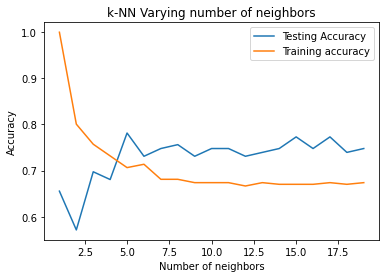

In [46]:
#Setup arrays to store training and test accuracies
neighbors= np.arange(1,20)
train_accuracy =np.empty(19)
test_accuracy = np.empty(19)

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(x_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(x_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(x_test, y_test) 
    
#  Plotting the curv
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show() 

In our case study we had a binary classification sow it could be better to choose an odd value of K.
 By looking into the curv We can observe above that we get maximum testing accuracy for **k=5** .In next step let's confirm if 5 was a good choice by using gridsearchCV. 

<h5 style='color:green;font-family:cursive;font-size:4.5mm'>Method 2: (using GridSearchCV)</h5>

In this step we will confirm if our tuning is correct for k_value by using gridsearch cross-validation .
    "Hyperparameter tuning is used in order to determine the optimal values for a given model. As mentioned above, the performance of a model significantly depends on the value of hyperparameters. Note that there is no way to know in advance the best values for hyperparameters so ideally, we need to try all possible values to know the optimal values. Doing this manually could take a considerable amount of time and resources and thus we use **GridSearchCV** to automate the tuning of hyperparameters.

**1) best k for training:**

In [47]:
#In case of classifier like knn the parameter to be tuned is n_neighbors 
param_grid = {'n_neighbors':np.arange(1,20)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(x_train,y_train)
#best score\n",
knn_cv.best_score_

0.6449350649350649

In [48]:
knn_cv.best_params_

{'n_neighbors': 19}

**2) best k for testing:**

In [49]:
param_grid = {'n_neighbors':np.arange(1,20)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(x_test,y_test)
#best score\n",
knn_cv.best_score_

0.7728260869565217

In [50]:
knn_cv.best_params_

{'n_neighbors': 13}

**2) best k for all the dataset:**

In [51]:
param_grid = {'n_neighbors':np.arange(1,20)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(x,y)
#best score\n",
knn_cv.best_score_

0.6734177215189873

In [52]:
knn_cv.best_params_

{'n_neighbors': 7}

**To conclude the best k for:**

1)training is :**19**

2)testing is :**13**

3)all the dataset:**7**

-----------------------------we had 2 choices **k=7** and **k=19** (choosing odd number for binary classification)-----------------------------------------------


<h5 style='color:green;font-family:cursive;font-size:4.5mm'>Method 3: </h5>

In this method we are going to fixe the value of k to k= 17 and  search for Best metric(distance)  based on time and acc .

In [53]:
params = {"n_neighbors":[7,19] , "metric":["euclidean", "manhattan", "chebyshev"]}
acc = {}

for m in params["metric"]:
    acc[m] = []
    for k in params["n_neighbors"]:
        print("Model_{} metric: {}, n_neighbors: {}".format(i, m, k))
        i += 1
        t = time()
        knn = KNeighborsClassifier(n_neighbors=k, metric=m)
        knn.fit(x_train,y_train)
        pred = knn.predict(x_test)
        print("Time: ", time() - t)
        acc[m].append(accuracy_score(y_test, y_pred))
        print("Acc: ", acc[m][-1])

Model_18 metric: euclidean, n_neighbors: 7
Time:  0.022012710571289062
Acc:  0.7815126050420168
Model_19 metric: euclidean, n_neighbors: 19
Time:  0.01901412010192871
Acc:  0.7815126050420168
Model_20 metric: manhattan, n_neighbors: 7
Time:  0.021016359329223633
Acc:  0.7815126050420168
Model_21 metric: manhattan, n_neighbors: 19
Time:  0.02701735496520996
Acc:  0.7815126050420168
Model_22 metric: chebyshev, n_neighbors: 7
Time:  0.02001166343688965
Acc:  0.7815126050420168
Model_23 metric: chebyshev, n_neighbors: 19
Time:  0.02001476287841797
Acc:  0.7815126050420168


As  We can see  the  metrics or distances gives the same accuracy  but time is different,the optimal_time for k=7 is   0.019012451171875 . This choice  gives heigh Acc=78% with less time consuming compared to other distances the wining distance is **chebyshev**

<h5 style='color:blue;font-family:cursive;font-size:4.5mm'>third step: </h5>

In this method we are going to commbine **knn hyperparameters tuning** (second step) and  **the  optimal random state**(first step) to get high accuracy

### B)Final model implementation

As we discover in privious section the best parameters to implement knn algorithme are:
   - K=7
   - metric=chebyshev-distance

In [54]:
max_iteration = 0
maxF1 = 0
maxAccuracy = 0
optimal_state = 0
f1 = 0
accuracy = 0
True60 = False
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+ ', Current f1 : '+str(maxF1), end="\r")
    split_state = np.random.randint(1,100000000)-1
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=split_state)
    KNN = KNeighborsClassifier(n_neighbors=7,metric='chebyshev')
    KNN.fit(x_train,y_train)
    y_pred=KNN.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)*100
    
    if accuracy>maxAccuracy and f1>=0.5:
        maxF1 = f1 
        maxAccuracy = accuracy
        optimal_state = split_state
        if maxAccuracy>79:
            break
    
optimal_state = 29300362         
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=optimal_state)
KNN_f= KNeighborsClassifier(n_neighbors=7,metric='chebyshev')
KNN_f.fit(x_train,y_train)
y_pred=KNN_f.predict(x_test)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)*100
print('\n\n\n*Accuracy is: '+str(accuracy)+'\n*f1 score is: ',f1)

print ('random_state is ',optimal_state)

yt_knn,yp_knn= y_test,y_pred






*Accuracy is: 79.83193277310924
*f1 score is:  0.5423076923076924
random_state is  29300362


**-As we can see if we combine the best knn parameters and optimal state the acquracy improve from 78% to 79%**
It's clear that hyperparameters_tuning increase the result but most impactfull parameters are random_state

<h5 style='color:blue;font-family:cursive;font-size:4.5mm'>forth step: </h5>

**To evaluate our  model we are going to**
- use heatmap (matrice de confusion )
- use the precision recall and  F1 score for each class
- plotting the roc curve


1)**Confusion matrix**

Accuracy is:  0.7983193277310925


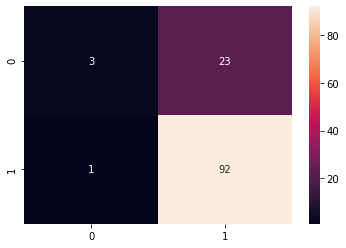

In [55]:
ac = accuracy_score(yt_knn,yp_knn)
print('Accuracy is: ',ac)
cm= confusion_matrix(yt_knn,yp_knn)
sns.heatmap(cm,annot=True)
yt_knn,yp_knn = y_test,y_pred

2)**classification_report**

In [56]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.12      0.20        26
         1.0       0.80      0.99      0.88        93

    accuracy                           0.80       119
   macro avg       0.78      0.55      0.54       119
weighted avg       0.79      0.80      0.74       119



 the ROC curve: 


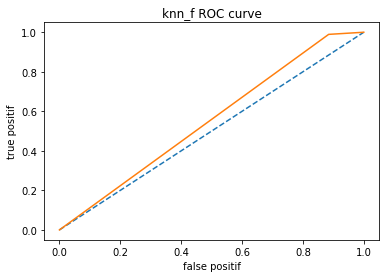

In [57]:
#ploting the roc_curve

print ( ' the ROC curve: ')

fpositif, tpositif, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'--')
plt.plot(fpositif,tpositif, label='final knn model')
plt.xlabel('false positif')
plt.ylabel('true positif')
plt.title('knn_f ROC curve')
p=plt.show()


<h5 style='color:red;font-family:cursive;font-size:4.5mm'> 4 Conclusion :</h5>

The main goal of this part was to understand the impact of knn_hyper_parameters_tuning. As a first step we implement a model that tune the optimal random_state without specifying knn_parameters, after we evaluate the model and we get an accuracy of 78%,next we search to increase this accuracy by fitting the model with the best parameters for that we search at first for the best k using the gridsearchCV and after we fix the best value of k and search for The best metrics. Finally, we got the best model with k=17 and metrics=chebychev and we got a better accuracy of 79% as we can see the impact of hyper_parameters wasn't so strong  the importent parameter is the randome_state.

# Support vector machine 

<h5 style='color:red;font-family:cursive;font-size:4.5mm'>Réalisé par Mohammed AL JADD </h5>

<img src='plots\project.cover\svm.jpeg' width='300cm' height='15cm'>



**First of all let's start with creating some useful functions :** The functions that we will use is :


<h5> 1) Showing results  :</h5>   

 - The first function will help us show the following metrics for any classifer : ROC curve, f1, accuracy, training time, ROC score and confusion matrix
 
```python
    def showResults(accuracy, trainingTime, y_pred,model) 
    ...
    
```    

<h5> 2) Hyperparameters tunning :</h5>

- First of all let's talk about the parameters that we will tune :
    - **C** : The C parameter tells the SVM optimization how much you want to avoid misclassifying each training example.
    
    - **d** : the degree of pylonomial that map feature to new features (e.g : suppose our hypothesis without polynomial features is $h_{\theta} = \theta_{0}+\theta_{1}.x_{1}$ then with polynomial features with d = 2 we get $h_{\theta} = \theta_{0}+\theta_{1}.x_{1}+\theta_{2}.x_{1}^{2}$).
    
    - **$\gamma$** : we talked about it in the  <a href='https://github.com/mohammedAljadd/Students-performance-and-difficulties-prediction#user-content-svm:~:text=Now%20after%20we%20train%20our%20three,by%20the%20model%20as%20support%20vectors.'> Readme file</a>.
    
    - **Data splits** : we will splits data randomly many times and choose the split that gives better performances. # we will see if we will tune this or not !
- we will use diffrent values of svm parameters and choose the ones who minimize the cost on the cross validation set, later on, we will split the data into three sets.
    
```python    
    def optimal_C_value()
    ...
    def optimal_C_d_values()
    ...
    def optimal_C_gamma_values()
    ...
```   
- This function will plot results of the three svm kernels that we will train :

<h5> 3) Comparison : :</h5>

```python
    def compare_kernels()
    ...
```   
- Show results of the best svm kernel according to the metrics :
```python 
 
    def best_kernel(kernel)
    ...
```

<h5>4) Impact factors :</h5>


- This three function will help us extract positive and negative factors for student performances on exams :

```python
    def factors(array, K, max_or_min, df)
    ...
    def get_factors(index, df)
    ...
    def column_to_string(fcts,max_or_min)
```

<h5>5) Dataset splitting :</h5>


- This function will split the data into three sets: **training set** :$(X_{train},Y_{train})$ used for training our classifiers, **cross validation set** :$(X_{cv},Y_{cv})$ used for tunning our hyperparameters, **test set** :$(X_{test},Y_{test})$ used for evaluation our classifiers.

```python
    def split(df,rest_size,test_size,randomState)
    ...
```

- This function takes four arguments:
    - <span style='color:red'>$df$</span> : Our dataset.
    - <span style='color:red'>$rest\_size$</span> : The size of the rest after loading  the $(X_{train},Y_{train})$, it means that the size of $(X_{train},Y_{train})$ is $1-rest\_size$.
    - <span style='color:red'>$test\_size$</span> : The size of $(X_{test},Y_{test})$
    - <span style='color:red'>$randomState$</span> : Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls

- This function returns six variables:
    - <span style='color:red'>$X\_train,X\_val,X\_test,y\_train,y\_val,y\_test$</span>

- We will explain each of these functions very well inside the following cell itself :

In [58]:
# Mohammed AL JADD


# ------------------------------------------------------------------------------------------------------------------------------
# Show results of every model

def showResults(accuracy, trainingTime, y_pred,model):
    
    print('------------------------------------------------Results :',model,'-------------------------------------------------')
    confusionMatrix = confusion_matrix(y_test, y_pred)
    print('\n The ROC curve is :\n')
    fig, _ = plt.subplots()
    fpr,tpr,thresholds=roc_curve(y_test,y_pred)
    plt.plot([0, 1],[0, 1],'--')
    plt.plot(fpr,tpr,label=model)
    plt.xlabel('false positive')
    plt.ylabel('false negative')
    plt.legend()
    fig.suptitle('ROC curve: '+str(model))
    plt.show()
    
    print('----------------------------------------------')
    print('The model  accuracy:', round(accuracy),'%')
    print('----------------------------------------------')
    print('The training time is: ',trainingTime)
    print('----------------------------------------------')
    print('The f1 score is :',round(100*f1_score(y_test, y_pred, average='macro'))/100)
    print('----------------------------------------------')
    print('The roc_auc_score is :',round(100*roc_auc_score(y_test, y_pred))/100)
    print('----------------------------------------------')
    print('The confusion matrix is :\n')
    ax = plt.axes()
    sns.heatmap(confusionMatrix,annot=True)


    
# ------------------------------------------------------------------------------------------------------------------------------
# Hyperparameter Tuning :
# C, degree and gamma are the parameters that are used in SVM classffier 'svc(C=..,..),svc(C,degree=..)',svc(C,gamma=..)
# The following functions will return those values that minimize the error on (X_val,y_val) set
# So this (X_val,y_val) set will be used to get the optimal SVM parameters before evaluating the model on the test set


# Optimal C 
def optimal_C_value():
    Ci = np.array(( 0.0001,0.001,0.01,0.05,0.1,4,10,40,100))
    minError = float('Inf')
    optimal_C = float('Inf')

    for c in Ci:
        clf = SVC(C=c,kernel='linear')
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_val)
        error = np.mean(np.double(predictions != y_val))
        if error < minError:
            minError = error
            optimal_C = c
    return optimal_C


# Optimal C and the degree of the polynomial
def optimal_C_d_values():
    Ci = np.array(( 0.0001,0.001,0.01,0.05,0.1,4,10,40,100))
    Di = np.array(( 2, 5, 10, 15, 20, 25, 30))
    minError = float('Inf')
    optimal_C = float('Inf')
    optimal_d = float('Inf')

    for d in Di:
        for c in Ci:
            clf = SVC(C=c,kernel='poly', degree=d)
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_val)
            error = np.mean(np.double(predictions != y_val))
            if error < minError:
                minError = error
                optimal_C = c
                optimal_d = d
    return optimal_C,optimal_d


# Optimal C and gamma
def optimal_C_gamma_values():
    Ci = np.array(( 0.0001,0.001,0.01,0.05,0.1,4,10,40,100))
    Gi = np.array(( 0.000001,0.00001,0.01,1,2,3,5,20,70,100,500,1000))
    minError = float('Inf')
    optimal_C = float('Inf')
    optimal_g = float('Inf')

    for g in Gi:
        for c in Ci:
            clf = SVC(C=c,kernel='rbf', gamma=g)
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_val)
            error = np.mean(np.double(predictions != y_val))
            if error < minError:
                minError = error
                optimal_C = c
                optimal_g = g
    return optimal_C,optimal_g


# ------------------------------------------------------------------------------------------------------------------------------
# Compare the three kernels


def compare_kernels():
    X_train1,X_val1,X_test1,y_train1,y_val1,y_test1 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state1)
    X_train2,X_val2,X_test2,y_train2,y_val2,y_test2 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state2)
    X_train3,X_val3,X_test3,y_train3,y_val3,y_test3 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state3)
    print('------------------------------------------------ Comparison -----------------------------------------------------')
    print('\n')
    f11 = "{:.2f}".format(f1_score(y_test1, y_linear, average='macro'))
    f22 = "{:.2f}".format(f1_score(y_test2, y_poly, average='macro'))
    f33 = "{:.2f}".format(f1_score(y_test3, y_gauss, average='macro'))
    roc1 = "{:.2f}".format(roc_auc_score(y_test1, y_linear))
    roc2 = "{:.2f}".format(roc_auc_score(y_test2, y_poly))
    roc3 = "{:.2f}".format(roc_auc_score(y_test3, y_gauss))
    a1,a2 = confusion_matrix(y_test1, y_linear)[0],confusion_matrix(y_test1, y_linear)[1]
    b1,b2 = confusion_matrix(y_test2, y_poly)[0],confusion_matrix(y_test2, y_poly)[1]
    c1,c2 = confusion_matrix(y_test3, y_gauss)[0],confusion_matrix(y_test3, y_gauss)[1]
    data_rows = [('training time',time1, time2, time3),
                 ('','','',''),
                  ('accuracy %',linear_accuracy, poly_accuracy, gauss_accuracy),
                 ('','','',''),
                 ('confusion matrix',a1, b1, c1),
                ('',a2,b2,c2),
                 ('','','',''),
                ('f1 score',f11,f22,f33),
                 ('','','',''),
                ('roc_auc_score',roc1,roc2,roc3)]
    t = Table(rows=data_rows, names=('metric','Linear kernel', 'polynomial kernel', 'gaussian kernel'))
    print(t)
    print('\n\n')
    print('The Roc curves :\n')
    y_pred1 = y_linear
    y_pred2 = y_poly
    y_pred3 = y_gauss
    fig, _ = plt.subplots()
    fig.suptitle('Comparison of three ROC curves')
    fpr,tpr,thresholds=roc_curve(y_test1,y_pred1)
    plt.plot([0, 1],[0, 1],'--')
    plt.plot(fpr,tpr,label='Linear kernel :'+str(roc1))
    plt.xlabel('false positive')
    plt.ylabel('false negative')
    fpr,tpr,thresholds=roc_curve(y_test2,y_pred2)
    plt.plot(fpr,tpr,label='Polynomial kernel :'+str(roc2))
    fpr,tpr,thresholds=roc_curve(y_test3,y_pred3)
    plt.plot(fpr,tpr,label='Gaussian kernel :'+str(roc3))
    plt.legend()
    plt.show()
    

# ------------------------------------------------------------------------------------------------------------------------------
# Print results of the choosen kernel

def best_kernel(kernel):
    X_train1,X_val1,X_test1,y_train1,y_val1,y_test1 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state1)
    X_train2,X_val2,X_test2,y_train2,y_val2,y_test2 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state2)
    X_train3,X_val3,X_test3,y_train3,y_val3,y_test3 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state3)
    
    time = 0
    f1 = 0
    accuracy = 0
    rc = 0
    y = 0
    if kernel == 'linear kernel':
        time = time1
        f1 = "{:.2f}".format(f1_score(y_test1, y_linear, average='macro'))
        accuracy = round(100*linear_accuracy)/100
        rc = round(100*roc_auc_score(y_test1, y_linear))/100
        y_test = y_test1
        y = y_linear
    elif kernel == 'polynomial kernel':
        time = time2
        f1 = "{:.2f}".format(f1_score(y_test2, y_poly, average='macro'))
        accuracy = round(100*poly_accuracy)/100
        rc = round(100*roc_auc_score(y_test2, y_poly))/100
        y_test = y_test2
        y = y_poly
    else :
        time = time3
        f1 = "{:.2f}".format(f1_score(y_test3, y_gauss, average='macro'))
        accuracy = round(100*gauss_accuracy)/100
        rc = round(100*roc_auc_score(y_test3, y_gauss))/100
        y_test = y_test3
        y = y_gauss 
        
    # used for comparing three classfiers(knn, logistic regression and svm)
    yt_svm,yp_svm = y_test, y
    
    print('The choosen kernel :',kernel)
    print('the training :',time)
    print('the accuracy :',round(accuracy),'%')
    print('the f1 score :',f1)
    print('The roc_auc_score is :',rc)
    print('----------------------------------------\nThe ROC curve :')
    fig, _ = plt.subplots()
    fpr,tpr,thresholds=roc_curve(y_test,y)
    plt.plot([0, 1],[0, 1],'--')
    plt.plot(fpr,tpr,label=kernel+': '+str(rc))
    plt.xlabel('false positive')
    plt.ylabel('false negative')
    plt.legend()
    plt.show()
    confusionMatrix = confusion_matrix(y_test, y)
    print('----------------------------------------\nThe confusion matrix is  :')
    ax = plt.axes()
    sns.heatmap(confusionMatrix,annot=True)
    ax.set_title('Confusion matrix of SVM '+str(kernel))
    return yt_svm,yp_svm
    
# ------------------------------------------------------------------------------------------------------------------------------
# svm factor : factor affecting students performance, later on on this Ipython notebook  we will explain how we will do this


# 1) factor as svm coefficients
def factors(array, K, max_or_min, df):
    
    n = array.shape[1]
    array = array.reshape(n,1)
    my_list = array.tolist()
    
    if max_or_min == 'max':
        temp = sorted(my_list)[-K:]
        res = [] 
        for ele in temp: 
            res.append(my_list.index(ele))
        return(get_factors(res, df))
    
    
    elif max_or_min == 'min':
        temp = sorted(my_list, reverse=True)[-K:]
        temp = temp = np.array(temp).reshape(K,1)
        res = []
        for ele in temp:
            if ele<0:
                res.append(my_list.index(ele))
        return(get_factors(res, df))
    

    else:
        return
    

# 2) converts those factors to dataset columns name
def get_factors(index, df):
    f = []
    for i in index:
        f.append(df.columns[i])
    return f
    

# 3) Convert column names to understandable string
 
columns_name = {'famsize': 'family size', 'Pstatus': "parent's cohabitation status ", 'Medu': "mother's education",
                'Fedu': "father's education", 'Mjob': "mother's job", 'Fjob': "father's job", 
                'reason': 'reason to choose this school ','schoolsup': 'extra educational support', 'famsup': 'family educational support',
                'paid': 'extra paid classes within the course subject', 'higher': 'wants to take higher education',
                'romantic': 'with a romantic relationship ', 'famrel': 'quality of family relationships', 'goout': 'going out with friends',
                'Dalc': 'workday alcohol consumption', 'Walc': 'weekend alcohol consumption'}        


def column_to_string(fcts,max_or_min):
    
    if max_or_min == 'max':
        print('-----------------------------------------------------------------------------------')
        print('Factors helping students succeed :')
    else:
        print('-----------------------------------------------------------------------------------')
        print('-----------------------------------------------------------------------------------')
        print('Factors leading students to failure')
        
    for fct in fcts:
        if fct in columns_name:
            print(columns_name[fct])
        else:
            print(fct)
    
    
# ------------------------------------------------------------------------------------------------------------------------------
# Splitting the data for SVM
# Here We will split data into test set, cross validation (X_val, y_val) set and training set
# The cross validation (X_val, y_val) is used for choosing the optimal value for svm parameters C, degree and gamma

def split(df,rest_size,test_size,randomState):
    data = df.to_numpy()
    n = data.shape[1]
    x = data[:,0:n-1]
    y = data[:,n-1]
    if(randomState):
        X_train,X_rest,y_train,y_rest = train_test_split(x,y,test_size=rest_size,random_state=randomState)
        X_val,X_test,y_val,y_test = train_test_split(X_rest,y_rest,test_size=test_size,random_state=randomState)
    else:
        X_train,X_rest,y_train,y_rest = train_test_split(x,y,test_size=rest_size,random_state=0)
        X_val,X_test,y_val,y_test = train_test_split(X_rest,y_rest,test_size=test_size,random_state=0)
    
    return X_train,X_val,X_test,y_train,y_val,y_test
# We will use the three different svm classifier kernels
# Linear kernel, polynomial kernel and gaussian kernel and we will choose the most accurate

<h2><span style='color:#b846a3;font-family:Comic Sans MS'>1) Model evaluation: :</span></h2>

For model evaluation we will calculate :

- <span style='color:red'>**Training time**</span>
- <span style='color:red'>**Accuracy**</span>
- <span style='color:red'>**Confusion matrix**</span>
- <span style='color:red'>**ROC curve**</span>
- <span style='color:red'>**ROC score**</span>
- <span style='color:red'>**f1 score**</span>

<h2><span style='color:#b846a3;font-family:Comic Sans MS'>2) Training phase :</span></h2>

   - <span style='color:#d61111'>**Note that**</span> **we will not loop over all the hyperparameters again, we've already done that and find the optimal values, if you want to tune those hyperparamtetrs again, just set the *max_iteration* to 2000 for example comment the line where we set the optimal value for *split random_state***.
   
   <br>
   - <span style='color:#d61111'>**Another thing to keep in mind is that** </span>**I haven't tuned our hyperparamters with a big number of iterations until I made sure that the model is not suffering from neither high bias nor high variance.**
<img src='https://i.stack.imgur.com/6PRan.png' width="102" height="32" style="float:right">

<h3><span style='color:#0759e6;font-family:Rockwell'>I. Linear Kernel :</span></h3>

------------------------------------------------Results : SVM linear kernel -------------------------------------------------

 The ROC curve is :



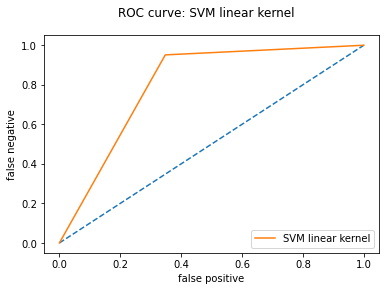

----------------------------------------------
The model  accuracy: 84.0 %
----------------------------------------------
The training time is:  0ms
----------------------------------------------
The f1 score is : 0.82
----------------------------------------------
The roc_auc_score is : 0.8
----------------------------------------------
The confusion matrix is :



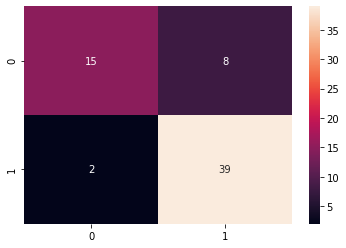

In [59]:
###################################################### Linear kernel ###########################################################
optimal_split_state1 = 0
maxAccuracy = 0
maxF1 = 0

# We already tune parameters, we do not need to loop over all the hyperparamters again, 
# if you want to do so just set max_iteration to 2000 for example 
# and remove the line 'optimal_split_state = 388628375' at the bottom of this cell.

max_iteration = 0
if max_iteration != 0:
    print ('----------------------------------------Hyperparameters tunning starts----------------------------------------\n\n')

for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+' Current f1 '+str(maxF1), end="\r")
    # Let's get the optimal C value for the linear kernal
    split_state = np.random.randint(1,1000000000)-1
    X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=split_state)
    optimal_C = optimal_C_value()


    # Now let's use the optimal C value
    linear_clf = SVC(C=optimal_C,kernel='linear')

    # Let's train the model with the optimal C value and calculate the training time
    tic = time()
    linear_clf.fit(X_train, y_train)
    toc = time()
    time1 = str(round(1000*(toc-tic))) + "ms"
    y_linear = linear_clf.predict(X_test)
    linear_f1 = f1_score(y_test, y_linear, average='macro')
    linear_accuracy = accuracy_score(y_test, y_linear)*100
    if linear_accuracy>maxAccuracy and linear_f1>maxF1:
        maxAccuracy = linear_accuracy
        maxF1 = linear_f1
        optimal_split_state1 = split_state
    if maxAccuracy>86 and maxF1>80:
        break;
        
# We've already tuned our hyperparameters, we will not repeat that again as it takes soo long. 
# The optimal split state for linear kernel is 388628375
# Let's try that split state 
optimal_split_state1 = 388628375
X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state1)
optimal_C = optimal_C_value()


# Now let's use the optimal C value
linear_clf = SVC(C=optimal_C,kernel='linear')

# Let's train the model with the optimal C value and calculate the training time
tic = time()
linear_clf.fit(X_train, y_train)
toc = time()
time1 = str(round(1000*(toc-tic))) + "ms"
y_linear = linear_clf.predict(X_test)
linear_accuracy = accuracy_score(y_test, y_linear)*100
if max_iteration != 0:
    print('\n\n\n                            ---------------------------process ended'\
         '------------------------------------                            \n\n\n')

# Let's show the resuls
showResults(linear_accuracy, time1, y_linear,'SVM linear kernel')

<h6>Conclusion</h6>

   - As you can see the metrics show that our linear kernel svm classifier is very effective, an accuracy of **84 %** is much acceptable for our problem, the confusion matric is roughly diagonal which indicate that our classifier is able to label your data correctly.

<h3><span style='color:#0759e6;font-family:Rockwell'>II. Polynomial Kernel :</span></h3>

------------------------------------------------Results : SVM polynomial kernel -------------------------------------------------

 The ROC curve is :



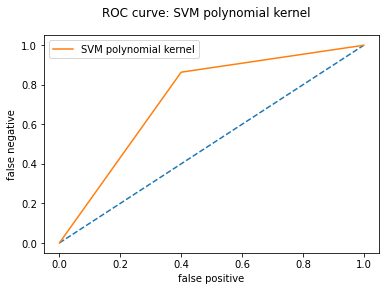

----------------------------------------------
The model  accuracy: 78.0 %
----------------------------------------------
The training time is:  16ms
----------------------------------------------
The f1 score is : 0.74
----------------------------------------------
The roc_auc_score is : 0.73
----------------------------------------------
The confusion matrix is :



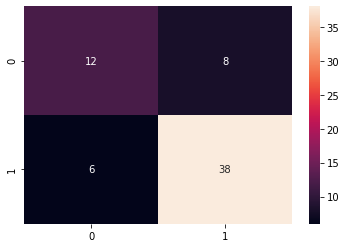

In [60]:
###################################################### Polynomial kernel #######################################################
optimal_split_state2 = 0
maxAccuracy = 0
maxF1 = 0


# We already tune parameters, we do not need to loop over all the hyperparamters again, 
# if you want to do so just set max_iteration to 500 for example 
# and remove the line 'optimal_split_state2 = 7070621' at the bottom of this cell.

max_iteration = 0
if max_iteration != 0:
    print ('----------------------------------------Hyperparameters tunning starts----------------------------------------\n\n')
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+', Current f1 '+str(maxF1), end="\r")
    
    split_state = np.random.randint(1,100000000)-1
    X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=split_state)

    # Let's get the optimal C and the degree value for the polynomial kernal
    optimal_C, optimal_d = optimal_C_d_values()
    
    # Now let's use the optimal c value and the optimal degree value
    poly_clf = SVC(C=optimal_C,kernel='poly', degree=optimal_d)

    # Let's train the model with the optimal C value 
    poly_clf.fit(X_train, y_train)
    y_poly = poly_clf.predict(X_test)
    poly_f1 = f1_score(y_test, y_poly, average='macro')
    poly_accuracy = accuracy_score(y_test, y_poly)*100
    
    if poly_accuracy>maxAccuracy and poly_f1>maxF1:
        maxAccuracy = poly_accuracy
        maxF1 = poly_f1
        optimal_split_state2 = split_state

# We've already tuned our hyperparameters, we will not repeat that again as it takes soo long. 
# The optimal split state for polynomial kernel is 7070621
# Let's try that split state 
optimal_split_state2 = 7070621

X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state2)

optimal_C, optimal_d = optimal_C_d_values()


# Now let's use the optimal C value
poly_clf = SVC(C=optimal_C,kernel='poly', degree=optimal_d)

# Let's train the model and calculate the training time
tic = time()
poly_clf.fit(X_train, y_train)
toc = time()
time2 = str(round(1000*(toc-tic))) + "ms"
y_poly = poly_clf.predict(X_test)
poly_accuracy = accuracy_score(y_test, y_poly)*100
if max_iteration != 0:
    print('\n\n\n                            ---------------------------process ended'\
         '------------------------------------                            \n\n\n')

# Let's show the resuls
showResults(poly_accuracy, time2, y_poly,'SVM polynomial kernel')

<h6>Conclusion</h6>

   - As you can see the metrics show that our polynomial kernel svm classifier is not effective that much, an accuracy of **78 %** is not that good for our problem, the confusion matric indicates that our classifier miss labeled some data.

<h3><span style='color:#0759e6;font-family:Rockwell'>III. Gaussian Kernel :</span></h3>

------------------------------------------------Results : SVM gaussian kernel -------------------------------------------------

 The ROC curve is :



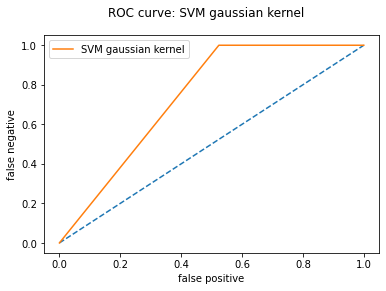

----------------------------------------------
The model  accuracy: 83.0 %
----------------------------------------------
The training time is:  0ms
----------------------------------------------
The f1 score is : 0.77
----------------------------------------------
The roc_auc_score is : 0.74
----------------------------------------------
The confusion matrix is :



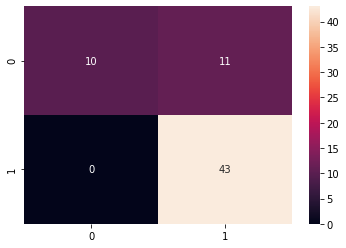

In [62]:
###################################################### Gaussian kernel ######################################################
optimal_split_state3 = 0
maxAccuracy = 0
maxF1 = 0


# We already tune parameters, we do not need to loop over all the hyperparamters again, 
# if you want to do so just set max_iteration to 500 for example 
# and remove the line 'optimal_split_state3 = 93895097' at the bottom of this cell.

max_iteration = 0
if max_iteration != 0:
    print ('----------------------------------------------Hyperparameters tunning starts'\
          '--------------------------------------------\n\n')
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+', Current f1 '+str(maxF1), end="\r")
    
    split_state = np.random.randint(1,100000000)-1
    X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=split_state)

    # Let's get the optimal C and the degree value for the polynomial kernal
    optimal_C, optimal_gamma = optimal_C_gamma_values()
    
    # Now let's use the optimal c value and the optimal degree value
    gauss_clf = SVC(C=optimal_C,kernel='rbf',gamma=optimal_gamma)

    # Let's train the model with the optimal C value 
    gauss_clf.fit(X_train, y_train)
    y_gauss = gauss_clf.predict(X_test)
    gauss_f1 = f1_score(y_test, y_gauss, average='macro')
    gauss_accuracy = accuracy_score(y_test, y_gauss)*100
    
    if gauss_accuracy>maxAccuracy and gauss_f1>maxF1:
        maxAccuracy = gauss_accuracy
        maxF1 = gauss_f1
        optimal_split_state3 = split_state

# We've already tuned our hyperparameters, we will not repeat that again as it takes soo long. 
# The optimal split state for polynomial kernel is 93895097
# Let's try that split state 
optimal_split_state3 = 93895097

X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state3)

optimal_C, optimal_gamma = optimal_C_gamma_values()


# Now let's use the optimal C value
gauss_clf = SVC(C=optimal_C,kernel='rbf',gamma=optimal_gamma)

# Let's train the model and calculate the training time
tic = time()
gauss_clf.fit(X_train, y_train)
toc = time()
time3 = str(round(1000*(toc-tic))) + "ms"
y_gauss = gauss_clf.predict(X_test)
gauss_accuracy = (accuracy_score(y_test, y_gauss)*100)

if max_iteration != 0:
    print('\n\n\n                            ---------------------------process ended'\
         '------------------------------------                            \n\n\n')
                                                                
# Let's show the resuls
showResults(gauss_accuracy, time3, y_gauss,'SVM gaussian kernel')

<h6>Conclusion</h6>

   - As you can see the metrics show that our gaussian kernel svm classifier is not effective comparing to linear kernel classifier, an accuracy of **78 %** is not that good for our problem, the confusion matric indicates that this classifier also miss labeled some data.

<h2><span style='color:#b846a3;font-family:Comic Sans MS'>3) Comparison of the three svm kernels: </span></h2>

**We will compare all the metrics and plots one graph containing all the three ROC curves of the three SVM kernels :**

```python
# we will just call the function :
def compare_kernels()

```

------------------------------------------------ Comparison -----------------------------------------------------


     metric      Linear kernel polynomial kernel gaussian kernel
---------------- ------------- ----------------- ---------------
   training time           0ms              16ms             0ms
                                                                
      accuracy %        84.375            78.125         82.8125
                                                                
confusion matrix       [15  8]           [12  8]         [10 11]
                       [ 2 39]           [ 6 38]         [ 0 43]
                                                                
        f1 score          0.82              0.74            0.77
                                                                
   roc_auc_score          0.80              0.73            0.74



The Roc curves :



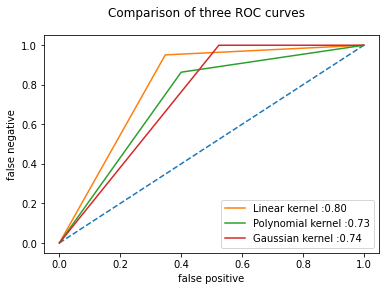

In [63]:
compare_kernels()

**What's the best values for those metrics:**
   - <span style='color:red'>**Accuracy**</span> : well, it depenes on your application, sometimes if you are working on a critical problem, say **malignant tumor prediction**, then *90 %* isn't good enough, but for our problem *+80 %* is much acceptable.
   - <span style='color:red'>**Confusion matrix**</span> : The confusion matrix should be nearly diagonal which indicates the classfier do not miss the test examples ($Y_{predicted} \approx Y_{test})$.
   - <span style='color:red'>**F1 score**</span> : say + 0.75 is good, we got 0.82 and it's a good value.
   - <span style='color:red'>**ROC curve**</span> : The curve should be way above the blue dashed line.
   - <span style='color:red'>**ROC score**</span> : Calcule the value of the surface under the ROC curve, an optimal value is 1, say + 0.75 is acceptable for our problem.

<h6>Conclusion :</h6>

- As you can see the **best svm kernel model is the one that used the linear kernel**, it performed very well on the test set as it has high accuracy as well as high f1 score. 

- If you see the Roc curve, you will notice that the orange curve is way above the blue dashed curve, this is why we got a high ROC score with a value of 0.8 which is the value of the surface under the <span style='color:#e36200'>orange curve</span>.

- We will choose the **linear kernel**.

<h2><span style='color:#b846a3;font-family:Comic Sans MS'>4) The most accurate svm kernel is the linear kernel: </span></h2>

```python
# ust call the function :
def best_kernel("linear kernel"), 
#we give it the parameter "linear kernel" as it's it's the most accurate.

```

The choosen kernel : linear kernel
the training : 0ms
the accuracy : 84.0 %
the f1 score : 0.82
The roc_auc_score is : 0.8
----------------------------------------
The ROC curve :


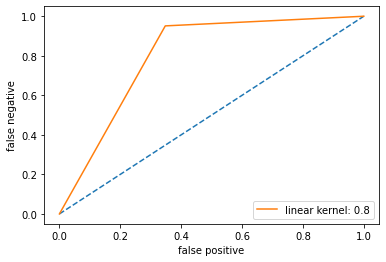

----------------------------------------
The confusion matrix is  :


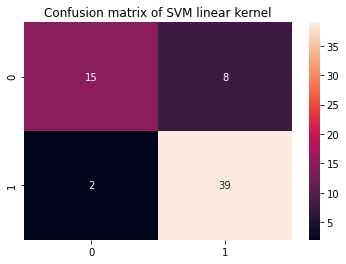

In [64]:
yt_svm,yp_svm = best_kernel('linear kernel')

<h2><span style='color:#b846a3;font-family:Comic Sans MS'>5) Factors affecting performances of studens using SVM classifer : </span></h2>
<h5 style='color:red;font-family:cursive;font-size:4.5mm'>Réalisé par Mohammed AL JADD </h5>
<img src='plots\project.cover\factors.jpg' width='400cm' height='400cm'>

- Before starting extracting factors affecting student performance let's talk about what a svm hypothesis look like :

$$h_{\theta}(x) = 
\begin{cases}
      1 & if& \theta^{T}.x > 0\\
      0 & &\text{otherwise}
    \end{cases} $$
    
In our problem, $h_{\theta}(x) = 1$ means that the student that has the given informations x passed the exam.
  
Where x is our feature vector and $\theta$ is the parameter vector learned when we called :
```python  
def ourClassifier.fit(Input_train, Output_train)

```
If you don't understand what is x, here it is :$x = \begin{bmatrix}
           school \\
           age \\
           address \\
           \vdots \\
           absences
         \end{bmatrix}
$
but do not forget that we've already numerized those values. <br><br>So $h_{\theta}(x) = \theta_{1}.school+\theta_{2}.age + \theta_{3}.address + ...\theta_{1}.absences$. <br><br>
This is a linear hypothesis of our features as we are using a linear kernel. 

So if we want to predict an output of an input x we simply calculate $h_{\theta}(x)$ and see if it's grather than 0 or not.

We can extract this $\theta$ vector and see what components of this vector decide whether or not $h_{\theta}(x)$ will be grather than 0.

**Now, let's explain how we will be able to know what factor for example will help students pass the final exam:** 

- Suppose we have a hypothesis $h_{\theta}(x) = \theta_{1}.x_{1} + \theta_{2}.x_{2}$. If $\theta_{1}$ is grather than 0, then a small positive change in $x_{1}$ will cause the value of $h_{\theta}(x)$ to rise, so the factor that affect our feature vector to belong to the positive class, y = 1, is simply $\theta_{1}$. But we have to extract also the factors affecting the negative class, y = 0. Simply, negative factors corresponding to the negative svm coefficients as they will cause the value of $h_{\theta}(x)$ to decrease.


We will do this by calling the following function :

```python
def factors(array, K, max_or_min, df)
...
```

Where :
- array is the $\theta$ components : $\theta_{1},\theta_{2},...,\theta_{n}$ where n is the number of features in x, in our case n = 30 .
- K : how many factors do we want
- max_or_min : min for negative class, max for positive class
- df : our numerised dataset.


<h4>The procedure :</h4>

- 1) get svm coefficients : $\theta_{1}, \theta_{2}, \theta_{3}, ... ,\theta_{n}$ by simply calling :
```python
    def coefs = classifier.coef_
    ...
```
- 2) convert those coefficients to understandable string. Example : $Fjob ---> Father's job$. To do that, just call :
```python
    def column_to_string(factors(coefs, K, minORmax, df),minORmax)
    ...
```
- <span style='color:red'>**Note that passing from svm coefficients to dataset column names is handled by** </span>:
```python
    def factors(...)
    ...
    # this function is used as parameter for
    def column_to_string(factors(...),minORmax)
    ...
```

    where **minORmax** : <br> 
    - **min** if we want factors leading students to failure
    - **max** if wa want factors helping students to succeed  

<h4 style='color:red'>Let's test our function :</h4>
    
   - Let's take five factors for the two classes ($class\ 0: did\ not\ passed, class 1: passed$):

In [65]:
# Get svm parameters
coefs = linear_clf.coef_

# factors helping students to succeed
column_to_string(factors(coefs, 5, 'max', df),'max')

# factors leading students to failure
column_to_string(factors(coefs, 5, 'min', df), 'min')

-----------------------------------------------------------------------------------
Factors helping students succeed :
father's education
guardian
wants to take higher education
studytime
father's job
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
Factors leading students to failure
age
health
going out with friends
absences
failures


**Conclusion :**

- ****1)**** For **<span style='color:red'>positive impact</span>**, it seems that the factors helping students succeed: <br><br>
    
   - **Father's education** : if the father has a higher education, he will help his children in their studies so that they will not struggle for a long time with their homeworks.
   <img src='plots\project.cover\father.jpg' width='300cm' height='130cm' style='display: block;margin-left: auto;margin-right: auto;'>
     
   - **Guardian** : This instance takes three values as our convention: 0,1 and 2, 2 refers to 'other', we conclude than if the guardian is neither mother nor father than the student has a big chance to succeed, but this just the result of our classifer, it is difficult to judge that.
    
   <img src='plots\project.cover\guardian.jpg' width='300cm' height='130cm' style='display: block;margin-left: auto;margin-right: auto;'>
    
   - **Wants to take higher education** : Students who are looking forward to take higher education seems to be motivated and having goals to achieve.
   <img src='plots\project.cover\higher.jpg' width='300cm' height='130cm' style='display: block;margin-left: auto;margin-right: auto;'>
    
   - **Study time** : This is an import thing to keep in mind, students need to spend many hours studying, do not imagine a student succeeding in his exams and yet do not spend one hour at his desk, but it depends on many things such as subject, timetable ...
   <img src='plots\project.cover\studytime.jpg' width='300cm' height='130cm' style='display: block;margin-left: auto;margin-right: auto;'>
    
   - **Father's job** : If the father has a good career, then of course he will fulfill the needs of their children in terms of paying additive classes, internet ...
   <img src='plots\project.cover\fatherjob.jpg' width='300cm' height='180cm' style='display: block;margin-left: auto;margin-right: auto;'>
    
<br><br>
- ****2)**** For **<span style='color:red'>negative impact</span>**, it seems that the factors affecting students are: <br><br>
    
    - **Age** : It is difficult to judge that the age is a negative factor, we do not have a big dataset to generalize, but we will assume it's a negative factor for the two choosen portuguese schools, so students should go to high school early.
    <img src='plots\project.cover\age.jpg' width='340cm' height='200cm' style='display: block;margin-left: auto;margin-right: auto;'>
    
    - **Health** : This can not be taken into consideration, we cannot say that students having good health fail in the exams, but we will assume again it's a negative factor for the two choosen portuguese schools as our classifier told us.
    <img src='plots\project.cover\health.jpg' width='340cm' height='170cm' style='display: block;margin-left: auto;margin-right: auto;'>
    
    - **Going out with friends** : going out with friends helps relieve stress, but sometimes if the students spend a lot of time outside the home this will definitely affect their studies.
    <img src='plots\project.cover\goout.jpg' width='340cm' height='190cm' style='display: block;margin-left: auto;margin-right: auto;'>
    
    - **Absences** : Students who missed classes will find it difficult to take the exams, sometimes you find students read a one month course in just one day, imagine how those students prepare for exams. Now, we did not talk about the students having problems letting them do that, we will later on talk abou that.
    <img src='plots\project.cover\absence.jpg' width='340cm' height='170cm' style='display: block;margin-left: auto;margin-right: auto;'>
    
    - **Failures** : Having a lot of failures is an indication of a lack of good exam preparations.
    
    <img src='plots\project.cover\fail.jpg' width='340cm' height='170cm' style='display: block;margin-left: auto;margin-right: auto;'>

    
<h6>Small conclusion on factors extraction:</h6>

- For positive impacts the classifier managed to give reasonable factors except the guardian factor, but if we see the negative factors, one or maybe two of them seems to be not right, **Age** and **Health**, I think Health isn't quit good factor to take into consideration if we want to generalize, but as we've said before we will assume that those are a negative factors, but we can say also it is a problem of lack of informations, 395 instances isn't quit big that much, we will assume that is convenient for the two chosen school, but if we see other factors it is indeed a good results.

<h6>Advices for students:</h6>

Now, based on extracted factors, let's give some advices for students, parents and school administration : 

   - People should get educated especially men so that they help their children in their studies.
   - The government should help students whose parents are not rich that much so they get access to internet or  looking forward taking higher education.
   - Administration should send warnings to parents when students reach the maximum acceptable number of absences before exam period begin.
   - When students are having a lot of failures, the administration, teachers should search for the problems faced by this students and also get contact with the parents for more informations.
   - Student should find, at home, a suitable space to study, they need desks or just a small area when they can focus on their studies. Imagine how you would tell this student not to go out with his friends and spend a lot of time and yet their parents shout all the time in front of him. Parents should keep their problems for themselves. These students need love and peace at home. Students will then spend many hours studying at home.

# Comparison of the three algorithms <h5 style='color:red;font-family:cursive;font-size:4.5mm'>Réalisé par Mohammed AL JADD </h5>

- **Now let's we will compare the three classfiers that have been train by all the project members**.
- The metrics that we will be using to compare between those three algorithms are :
    - F1 score.
    - Accuracy score.
    - Confusion matrix.
    - ROC curve.
    - ROC score.
    
- This will be done by just calling the following function:
    
```python
def compare_lg_knn_svm(yt_knn,yp_knn,yt_lg,yp_lg,yt_svm,yp_svm)
```

- *Arguments* :
    - yt_knn : $y_{test}$ used in knn algorithm.
    - yp_knn : $y_{predicted}$ by knn algorithm.
    - yt_lg : $y_{test}$ used in logistic regression algorithm.
    - yp_lg : $y_{predicted}$ by logistic regression  algorithm.
    - yt_svm : $y_{test}$ used in svm algorithm.
    - yp_svm $y_{predicted}$ by svm algorithm.
    
- *Results* :
        - A table containing all metrics.
        - A graph containing the three ROC curves.
        - A table giving the good metric. For exmaple, f1 score is maximal for KNN learning algorithms.
        
- After that, we will choose the algorithm that seems to us the more accurate and also the one that do not neither overfit nor underfit by just seeing the other metrics such f1 score.
   
- **The following function is going to return the name of algorithm having the max metric value**

```python
def algo_with_max_metric(a,b,c)
```


In [66]:
# Function to compare the three classifiers (Logistic regression, KNN and SVM) performances :

def compare_lg_knn_svm(yt_knn,yp_knn,yt_lg,yp_lg,yt_svm,yp_svm):
    #F1 score
    f1_lg = round(f1_score(yt_lg, yp_lg, average='macro')*100)
    f1_knn = round(f1_score(yt_knn, yp_knn, average='macro')*100)
    f1_svm = round(f1_score(yt_svm, yp_svm, average='macro')*100)
    
    #Accuracy score
    acc_lg = round(accuracy_score(yt_lg, yp_lg)*100)
    acc_knn = round(accuracy_score(yt_knn, yp_knn)*100)
    acc_svm = round(accuracy_score(yt_svm, yp_svm)*100)
    
    #Confusion matrix
    conf_lg = confusion_matrix(yt_lg, yp_lg)
    conf_knn = confusion_matrix(yt_knn, yp_knn)
    conf_svm = confusion_matrix(yt_svm, yp_svm)
    
    #ROC score
    roc_c_lg = round(roc_auc_score(yt_lg, yp_lg)*100)
    roc_c_knn = round(roc_auc_score(yt_knn, yp_knn)*100)
    roc_c_svm = round(roc_auc_score(yt_svm, yp_svm)*100)
    
    #ROC curve thresholds
    roc_knn = roc_curve(yt_knn,yp_knn)
    roc_lg = roc_curve(yt_lg,yp_lg)
    roc_svm = roc_curve(yt_svm,yp_svm)
    
    # Table of metrics
    print('-----------------------------Table of metrics--------------------------------------\n\n')
    data_rows = [('f1 score',f1_lg,f1_knn,f1_svm),
                 ('','','',''),
                  ('accuracy %',acc_lg,acc_knn,acc_svm),
                 ('','','',''),
                 ('confusion matrix',conf_lg[0], conf_knn[0], conf_svm[0]),
                ('',conf_lg[1], conf_knn[1], conf_svm[1]),
                 ('','','',''),
                ('ROC score',roc_c_lg,roc_c_knn,roc_c_svm)]
    t = Table(rows=data_rows, names=('metric','Logistic regression', 'KNN', 'SVM'))
    print(t)
    
    #Plot ROC curve
    print('\n\n-----------------------------ROC curves--------------------------------------\n\n')
    fig, _ = plt.subplots()
    fig.suptitle('Comparison of three ROC curves')
    fpr,tpr,thresholds=roc_lg
    plt.plot([0, 1],[0, 1],'--')
    plt.plot(fpr,tpr,label='Logistic regression :'+str(roc_c_lg))
    plt.xlabel('false positive')
    plt.ylabel('false negative')
    fpr,tpr,thresholds=roc_knn
    plt.plot(fpr,tpr,label='KNN :'+str(roc_c_knn))
    fpr,tpr,thresholds=roc_svm
    plt.plot(fpr,tpr,label='SVM :'+str(roc_c_svm))
    plt.legend()
    plt.show()
    
    
    # Maximum metrics
    print('-----------------------------Max of metrics--------------------------------------\n\n')
    data_rows = [('max f1 score',algo_with_max_metric(f1_lg,f1_knn,f1_svm)),
                 ('','','',''),
                  ('max accuracy %',algo_with_max_metric(acc_lg,acc_knn,acc_svm)),
                 ('','','',''),
                ('max ROC score',algo_with_max_metric(roc_c_lg,roc_c_knn,roc_c_svm))]
    t = Table(rows=data_rows, names=('metric','Learning algorithm winnig'))
    print(t)
    
# Function returning name of winnig algorithm based on a single metric
def algo_with_max_metric(a,b,c):
    max_metric = max(a,b,c)
    if max_metric == a:
        return 'Logistic regression'
    elif max_metric == b:
        return 'KNN'
    else:
        return 'SVM'

-----------------------------Table of metrics--------------------------------------


     metric      Logistic regression   KNN     SVM  
---------------- ------------------- ------- -------
        f1 score                74.0    54.0    82.0
                                                    
      accuracy %                81.0    80.0    84.0
                                                    
confusion matrix             [18 17] [ 3 23] [15  8]
                             [ 6 78] [ 1 92] [ 2 39]
                                                    
       ROC score                72.0    55.0    80.0


-----------------------------ROC curves--------------------------------------




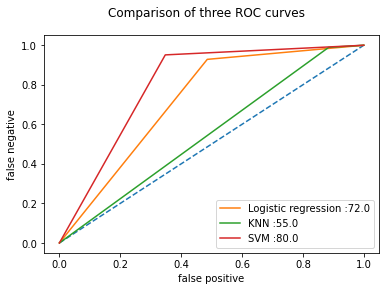

-----------------------------Max of metrics--------------------------------------


    metric     Learning algorithm winnig
-------------- -------------------------
  max f1 score                       SVM
                                        
max accuracy %                       SVM
                                        
 max ROC score                       SVM


In [67]:
compare_lg_knn_svm(yt_knn,yp_knn,yt_lg,yp_lg,yt_svm,yp_svm)

<h3><span style='color:#e34c00;font-family:Comic Sans MS'>Conclusion of selected classifier for our problem :</span></h3>

- As you can see the classifier with high metrics is the support vector machine classifier with high accuracy of **84%**, the confusion matrix is roughly diagonal which indicate that this classifier is able to label data correctly. If we see other metrics such as f1 score, we managed to have a good value of 0.82 which means that we have low false positives and low false negatives.

- Now let's go back and see the **advices** given for studens, parents and administration. Just <a href='#Advices-for-students:'> <span style='color:red;text-decoration: none'> Click here!</span></a>

# Conclusion <h5 style='color:red;font-family:cursive;font-size:4.5mm'>Réalisé par EL NABAOUI Nouhaila </h5>

    Improving the educational system is a big deal, As student engineers, we can contribute to realizing this goal by using technologies and study resources like machine learning materials ,to come up with an innovative solution to help the student in need especially student who live in hard conditions (demographic, social and educational problems). In this project, we come up with the idea to build a model that predicts student status based on different features. Our main challenges were to define the best classification algorithm and to identify the most impactful factors for student academic status,to provide them with a summary or valedictorian of student’s best conditions to reach high academics status and avoid failure. For this project entitled “”Students-performance and difficulties prediction””, we used several methods for classification such as logistic regression, KNN, and SVM and we evaluate this model using different metrics like f1 score, roc curve, and confusion matrix and finally we got a winner which SVM with an accuracy of 84% compared to KNN and logestic regression. Before achieving our main challenges they were several steps to take: -data processing -data visualization -Models implementation -comparison of 3 algorithm

<a href='#Students-performance-and-difficulties-prediction'><span style='color:red;text-decoration: none;font-family:cursive'><h4>Go Back!</h4></span></a>